In [1]:
# =========================================================
# CELL 1: Setup (Folders + Logging + Config) - Refactored
# =========================================================

import os
import sys
import json
import logging
from datetime import datetime

# -------------------- CONFIG --------------------
PROJECT_NAME = "bdg2_energy_anomaly_detection"
ROOT_DIR = f"/content/{PROJECT_NAME}"

DIRS = {
    "root": ROOT_DIR,
    "data": f"{ROOT_DIR}/data",
    "raw": f"{ROOT_DIR}/data/raw",
    "extracted": f"{ROOT_DIR}/data/extracted",
    "processed": f"{ROOT_DIR}/data/processed",
    "models": f"{ROOT_DIR}/models",
    "plots": f"{ROOT_DIR}/plots",
    "reports": f"{ROOT_DIR}/reports",
    "logs": f"{ROOT_DIR}/logs",
    "outputs": f"{ROOT_DIR}/outputs"
}

CONFIG = {
    "project_name": PROJECT_NAME,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "random_state": 42,
    "contamination": 0.05,                 # anomaly % target
    "rolling_window_hours": 168,           # 7 days rolling window
    "avg_kwh_cost_usd": 0.12,              # business estimation
    "evaluation_window_rows": 10000,       # fast evaluation slice
    "max_rows_for_demo": None              # keep None for full dataset
}

# -------------------- CREATE FOLDERS --------------------
for path in DIRS.values():
    os.makedirs(path, exist_ok=True)

# -------------------- LOGGER --------------------
log_file = f"{DIRS['logs']}/pipeline.log"

logger = logging.getLogger("BDG2_PIPELINE")
logger.setLevel(logging.INFO)

if not logger.handlers:
    fh = logging.FileHandler(log_file)
    ch = logging.StreamHandler(sys.stdout)

    fmt = logging.Formatter(
        "[%(asctime)s] [%(levelname)s] %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
    )
    fh.setFormatter(fmt)
    ch.setFormatter(fmt)

    logger.addHandler(fh)
    logger.addHandler(ch)

# -------------------- SAVE CONFIG --------------------
config_path = f"{DIRS['root']}/config.json"
with open(config_path, "w") as f:
    json.dump(CONFIG, f, indent=4)

logger.info("✅ Project initialized successfully")
logger.info(f"📌 Root Directory: {ROOT_DIR}")
logger.info(f"📝 Log file: {log_file}")
logger.info(f"⚙️ Config saved: {config_path}")

print("\n✅ Folder Structure Ready:")
for k, v in DIRS.items():
    print(f"{k:<10} -> {v}")

print("\n✅ NEXT STEP: Run CELL 2 to install packages + setup vibrant plotting utilities")


[2026-02-03 13:43:45] [INFO] ✅ Project initialized successfully


INFO:BDG2_PIPELINE:✅ Project initialized successfully


[2026-02-03 13:43:45] [INFO] 📌 Root Directory: /content/bdg2_energy_anomaly_detection


INFO:BDG2_PIPELINE:📌 Root Directory: /content/bdg2_energy_anomaly_detection


[2026-02-03 13:43:45] [INFO] 📝 Log file: /content/bdg2_energy_anomaly_detection/logs/pipeline.log


INFO:BDG2_PIPELINE:📝 Log file: /content/bdg2_energy_anomaly_detection/logs/pipeline.log


[2026-02-03 13:43:45] [INFO] ⚙️ Config saved: /content/bdg2_energy_anomaly_detection/config.json


INFO:BDG2_PIPELINE:⚙️ Config saved: /content/bdg2_energy_anomaly_detection/config.json



✅ Folder Structure Ready:
root       -> /content/bdg2_energy_anomaly_detection
data       -> /content/bdg2_energy_anomaly_detection/data
raw        -> /content/bdg2_energy_anomaly_detection/data/raw
extracted  -> /content/bdg2_energy_anomaly_detection/data/extracted
processed  -> /content/bdg2_energy_anomaly_detection/data/processed
models     -> /content/bdg2_energy_anomaly_detection/models
plots      -> /content/bdg2_energy_anomaly_detection/plots
reports    -> /content/bdg2_energy_anomaly_detection/reports
logs       -> /content/bdg2_energy_anomaly_detection/logs
outputs    -> /content/bdg2_energy_anomaly_detection/outputs

✅ NEXT STEP: Run CELL 2 to install packages + setup vibrant plotting utilities


In [2]:
# =========================================================
# CELL 2: Install + Imports + Vibrant Plot Style + Helpers
# =========================================================

!pip -q install pandas numpy scikit-learn matplotlib seaborn joblib tqdm

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

# Load config
ROOT_DIR = "/content/bdg2_energy_anomaly_detection"
with open(f"{ROOT_DIR}/config.json", "r") as f:
    CONFIG = json.load(f)

DIRS = {
    "root": ROOT_DIR,
    "data": f"{ROOT_DIR}/data",
    "raw": f"{ROOT_DIR}/data/raw",
    "extracted": f"{ROOT_DIR}/data/extracted",
    "processed": f"{ROOT_DIR}/data/processed",
    "models": f"{ROOT_DIR}/models",
    "plots": f"{ROOT_DIR}/plots",
    "reports": f"{ROOT_DIR}/reports",
    "logs": f"{ROOT_DIR}/logs",
    "outputs": f"{ROOT_DIR}/outputs"
}

# ------------------- VIBRANT STYLE -------------------
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["figure.dpi"] = 120

def save_plot(fig, filename: str):
    """Save plot in high resolution with clean layout."""
    out_path = os.path.join(DIRS["plots"], filename)
    fig.tight_layout()
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    print(f"✅ Plot saved: {out_path}")

def save_df(df: pd.DataFrame, filename: str):
    out_path = os.path.join(DIRS["outputs"], filename)
    df.to_csv(out_path, index=False)
    print(f"✅ File saved: {out_path} | shape={df.shape}")

print("✅ Packages installed and helper utilities loaded")
print("✅ NEXT STEP: Run CELL 3 to auto-download + extract BDG2 dataset")


✅ Packages installed and helper utilities loaded
✅ NEXT STEP: Run CELL 3 to auto-download + extract BDG2 dataset


In [3]:
# =========================================================
# CELL 3: Download FULL BDG2 dataset using kagglehub
# =========================================================

!pip -q install kagglehub

import os
import shutil
from glob import glob
import kagglehub

# 1) Download dataset (auto handles caching)
print("⏳ Downloading BDG2 dataset using kagglehub...")
path = kagglehub.dataset_download("claytonmiller/buildingdatagenomeproject2")
print("✅ Path to dataset files:", path)

# 2) Copy dataset into our project raw folder
DEST_DIR = f"{DIRS['raw']}/bdg2_kagglehub"
os.makedirs(DEST_DIR, exist_ok=True)

csv_files = glob(os.path.join(path, "*.csv"))
print(f"\n✅ CSV files found in kagglehub folder: {len(csv_files)}")

if len(csv_files) == 0:
    raise FileNotFoundError("❌ No CSV files found. kagglehub download may have failed.")

for f in csv_files:
    shutil.copy(f, DEST_DIR)

print(f"\n✅ Copied all CSVs into: {DEST_DIR}")

# 3) Verify all expected BDG2 files exist
expected_files = [
    "electricity.csv", "chilledwater.csv", "gas.csv", "hotwater.csv",
    "irrigation.csv", "solar.csv", "steam.csv", "water.csv",
    "electricity_cleaned.csv", "chilledwater_cleaned.csv", "gas_cleaned.csv",
    "hotwater_cleaned.csv", "irrigation_cleaned.csv", "solar_cleaned.csv",
    "steam_cleaned.csv", "water_cleaned.csv",
    "metadata.csv", "weather.csv"
]

missing = []
for f in expected_files:
    if not os.path.exists(os.path.join(DEST_DIR, f)):
        missing.append(f)

print("\n📌 Dataset verification report")
print(f"✅ Expected files: {len(expected_files)}")
print(f"✅ Found files    : {len(glob(os.path.join(DEST_DIR, '*.csv')))}")

if missing:
    print("\n⚠️ Missing files:")
    for m in missing:
        print(" -", m)
    raise FileNotFoundError("❌ Some expected BDG2 files are missing.")
else:
    print("\n✅ All expected BDG2 files are present (18/18)")

print("\n✅ NEXT STEP: Run CELL 4 to decide merge strategy and build final preprocessed dataset")


⏳ Downloading BDG2 dataset using kagglehub...


100%|██████████| 263M/263M [00:03<00:00, 76.8MB/s]

Extracting files...


✅ Path to dataset files: /root/.cache/kagglehub/datasets/claytonmiller/buildingdatagenomeproject2/versions/3

✅ CSV files found in kagglehub folder: 18

✅ Copied all CSVs into: /content/bdg2_energy_anomaly_detection/data/raw/bdg2_kagglehub

📌 Dataset verification report
✅ Expected files: 18
✅ Found files    : 18

✅ All expected BDG2 files are present (18/18)

✅ NEXT STEP: Run CELL 4 to decide merge strategy and build final preprocessed dataset


In [4]:
# =========================================================
# CELL 4: Verify Downloaded Files (Existence + Size + Preview)
# =========================================================

import os
import pandas as pd

DATA_DIR = f"{DIRS['raw']}/bdg2_kagglehub"

expected_files = [
    "electricity.csv", "chilledwater.csv", "gas.csv", "hotwater.csv",
    "irrigation.csv", "solar.csv", "steam.csv", "water.csv",
    "electricity_cleaned.csv", "chilledwater_cleaned.csv", "gas_cleaned.csv",
    "hotwater_cleaned.csv", "irrigation_cleaned.csv", "solar_cleaned.csv",
    "steam_cleaned.csv", "water_cleaned.csv",
    "metadata.csv", "weather.csv"
]

print("📌 Dataset Directory:", DATA_DIR)

# ------------------ 1) Existence Check ------------------
missing = [f for f in expected_files if not os.path.exists(os.path.join(DATA_DIR, f))]

if missing:
    print("\n❌ Missing files detected:")
    for m in missing:
        print(" -", m)
    raise FileNotFoundError("❌ Dataset download is incomplete. Fix before proceeding.")
else:
    print("\n✅ All 18/18 expected files are present")

# ------------------ 2) Size Check ------------------
print("\n📦 File size report (MB):")
sizes = []
for f in expected_files:
    path = os.path.join(DATA_DIR, f)
    size_mb = os.path.getsize(path) / (1024 * 1024)
    sizes.append((f, round(size_mb, 2)))

sizes_sorted = sorted(sizes, key=lambda x: x[1], reverse=True)
for name, mb in sizes_sorted:
    print(f"{name:<25} -> {mb:>8} MB")

# ------------------ 3) Preview a RAW meter file ------------------
def quick_preview_csv(filename, nrows=5):
    path = os.path.join(DATA_DIR, filename)
    df_temp = pd.read_csv(path, nrows=nrows)
    print(f"\n✅ Preview: {filename}")
    print("Shape (preview):", df_temp.shape)
    print("Columns:", df_temp.columns[:12].tolist(), "...")  # show first 12 columns
    print(df_temp.head(2))
    return df_temp

# Preview 1 raw meter file
raw_preview = quick_preview_csv("electricity.csv", nrows=5)

# Validate timestamp exists
if "timestamp" not in raw_preview.columns:
    raise ValueError("❌ 'timestamp' column missing in electricity.csv")

# ------------------ 4) Preview weather.csv ------------------
weather_preview = quick_preview_csv("weather.csv", nrows=5)
if "timestamp" not in weather_preview.columns:
    raise ValueError("❌ 'timestamp' column missing in weather.csv")

# ------------------ 5) Preview metadata.csv ------------------
metadata_preview = quick_preview_csv("metadata.csv", nrows=5)

print("\n✅ File validation complete ✅")
print("✅ NEXT STEP: Run CELL 5 to decide merge approach (RAW vs CLEANED) + build final preprocessed dataset")


📌 Dataset Directory: /content/bdg2_energy_anomaly_detection/data/raw/bdg2_kagglehub

✅ All 18/18 expected files are present

📦 File size report (MB):
electricity_cleaned.csv   ->   166.87 MB
electricity.csv           ->   166.17 MB
chilledwater.csv          ->    75.19 MB
chilledwater_cleaned.csv  ->    73.44 MB
steam.csv                 ->    44.58 MB
steam_cleaned.csv         ->    43.32 MB
hotwater.csv              ->    23.79 MB
hotwater_cleaned.csv      ->    23.23 MB
gas_cleaned.csv           ->    20.98 MB
gas.csv                   ->    19.25 MB
weather.csv               ->    18.56 MB
water.csv                 ->    14.92 MB
water_cleaned.csv         ->    14.68 MB
irrigation.csv            ->     3.01 MB
irrigation_cleaned.csv    ->     2.93 MB
solar.csv                 ->     0.71 MB
solar_cleaned.csv         ->      0.7 MB
metadata.csv              ->     0.26 MB

✅ Preview: electricity.csv
Shape (preview): (5, 1579)
Columns: ['timestamp', 'Panther_parking_Lorriane', 'Panth

📌 Loading RAW electricity.csv (lightweight mode)...
✅ Loaded electricity.csv
✅ Shape: (17544, 1579)
✅ Total building meter columns: 1578
✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/RAW_01_electricity_coverage_top30.png


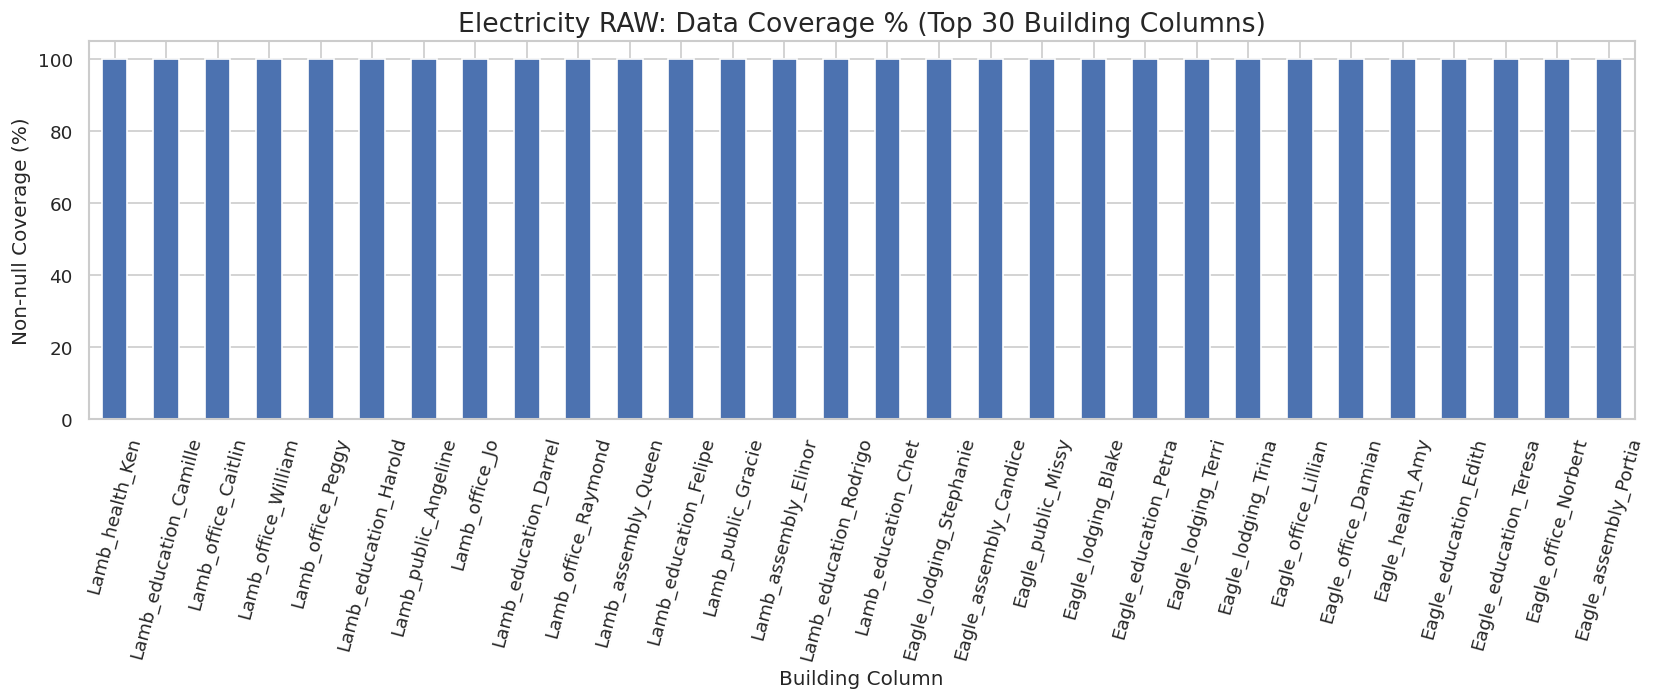

✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/RAW_02_electricity_value_distribution.png


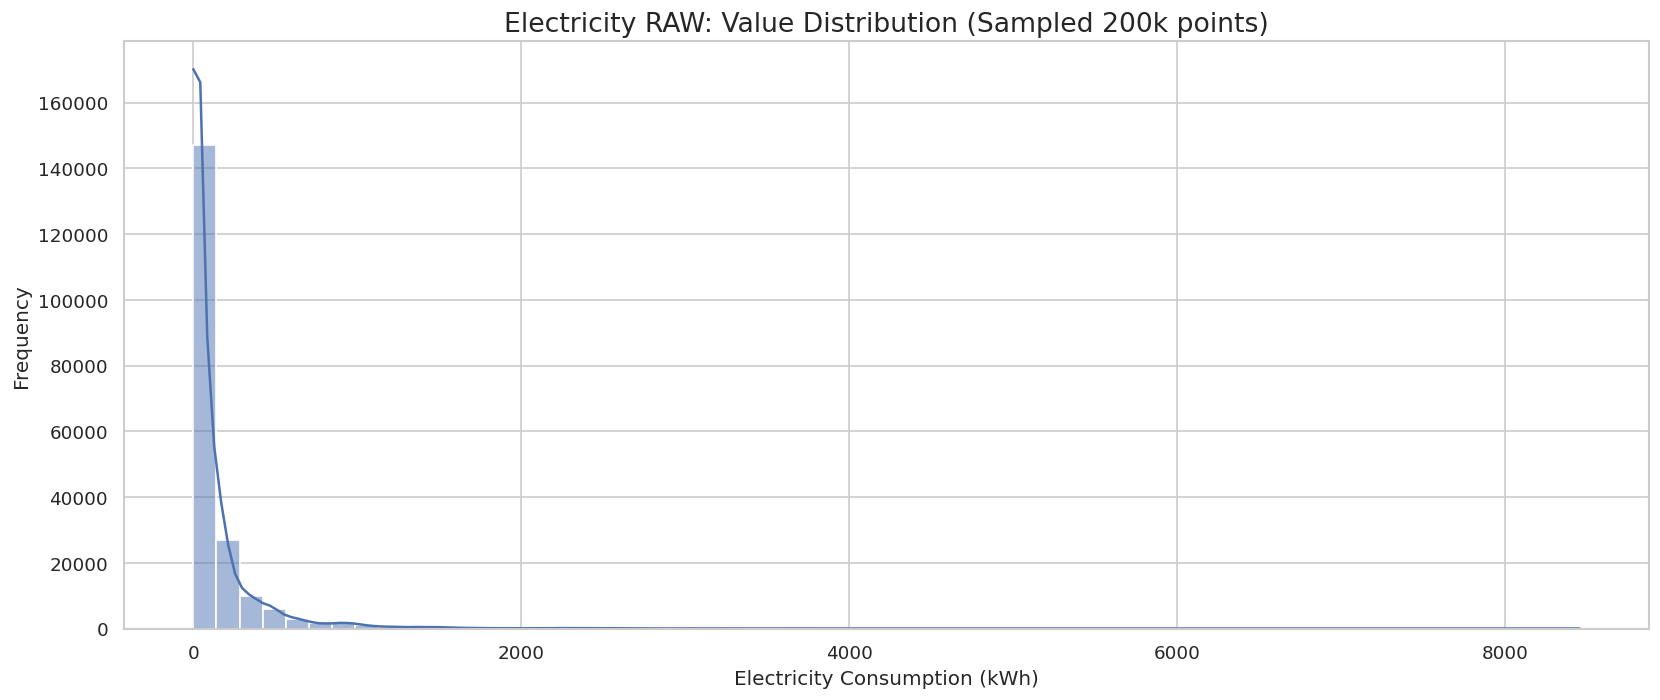

✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/RAW_03_electricity_3buildings_7days.png


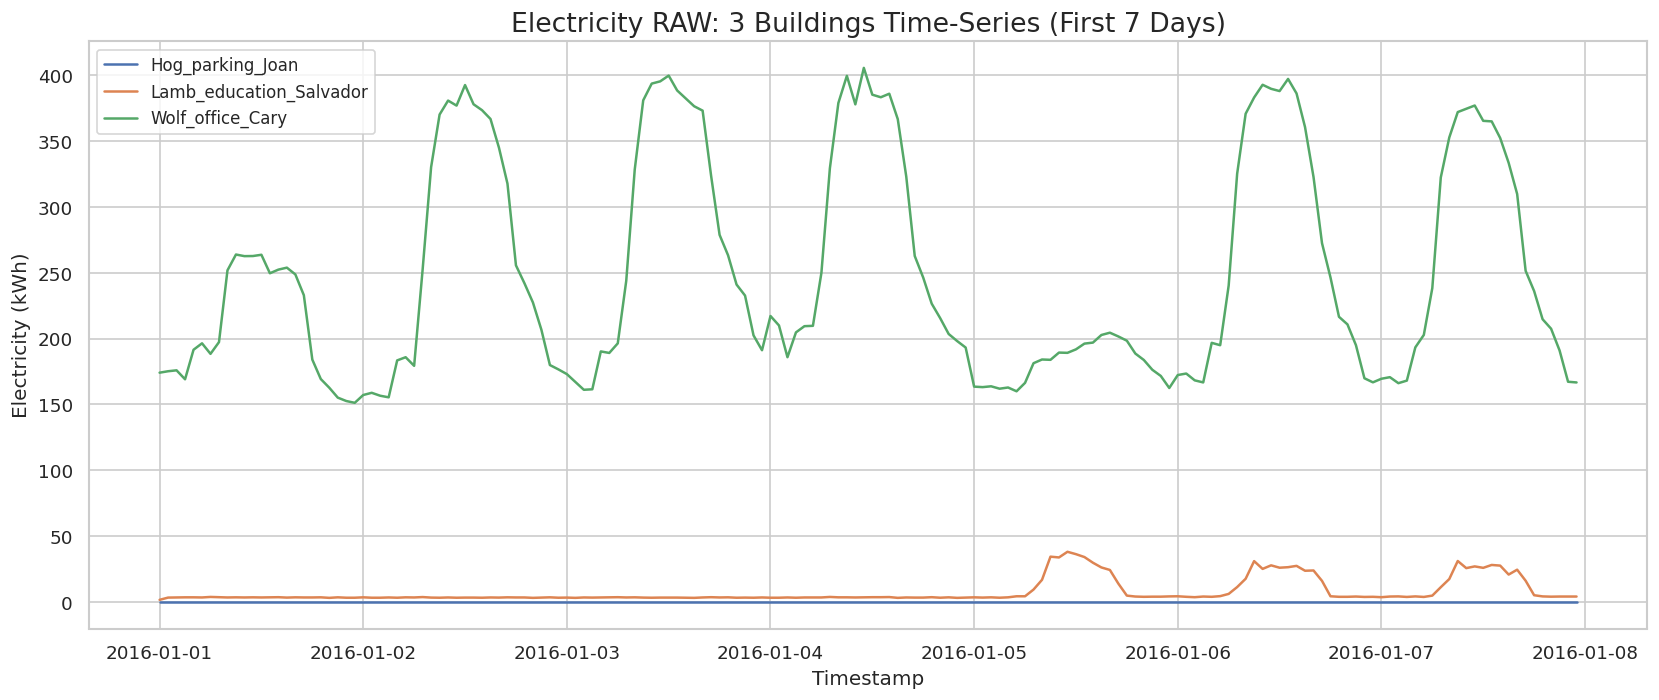

✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/RAW_04_missing_heatmap_sample.png


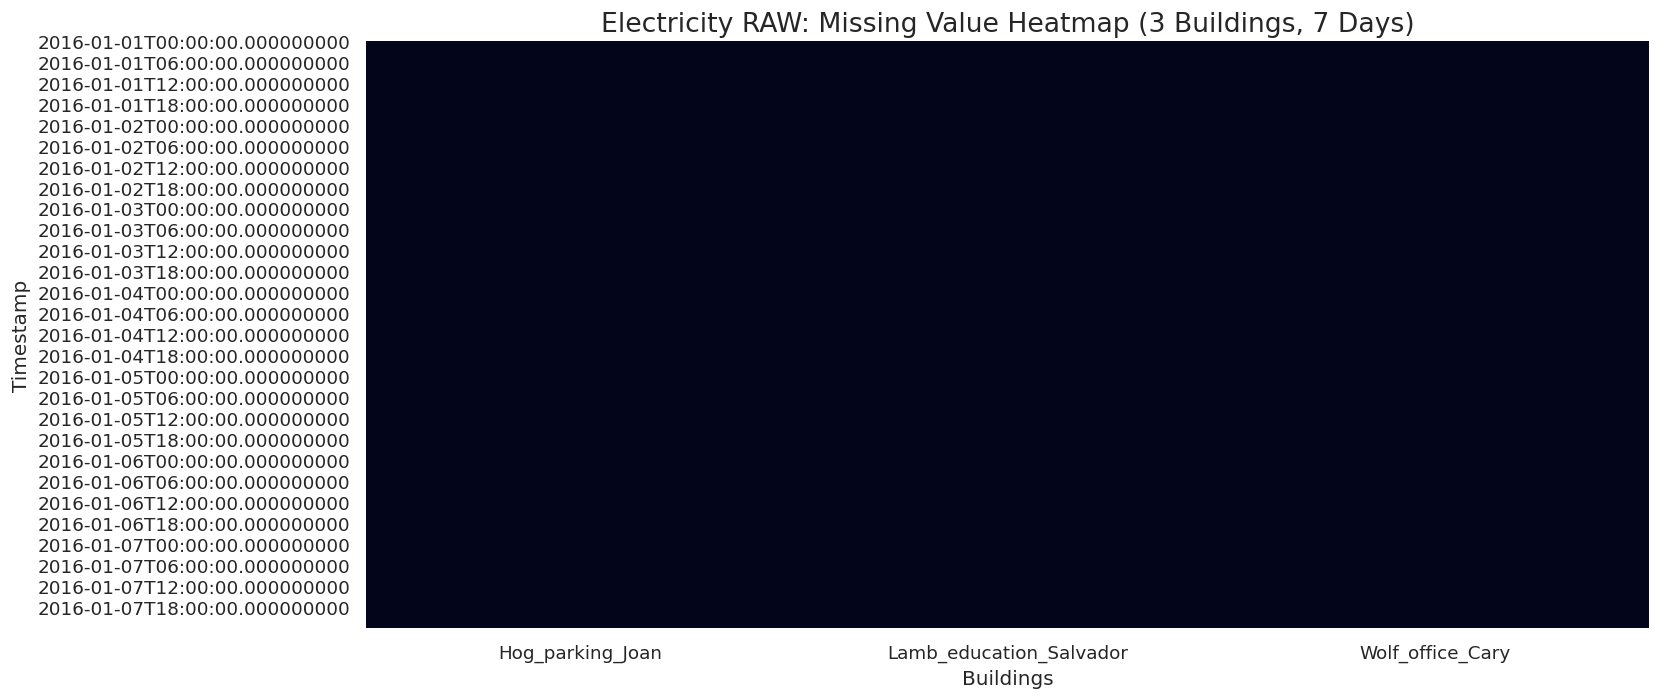


✅ RAW dataset EDA plots generated & saved in: /content/bdg2_energy_anomaly_detection/plots
✅ NEXT STEP: Run CELL 6 to build merged long-format dataset (RAW meters + weather + metadata)


In [5]:
# =========================================================
# CELL 5: RAW Dataset EDA Plots (Electricity) - Saved
# =========================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = f"{DIRS['raw']}/bdg2_kagglehub"
ELEC_FILE = os.path.join(DATA_DIR, "electricity.csv")

print("📌 Loading RAW electricity.csv (lightweight mode)...")
df_elec = pd.read_csv(ELEC_FILE)

print("✅ Loaded electricity.csv")
print("✅ Shape:", df_elec.shape)

# Convert timestamp
df_elec["timestamp"] = pd.to_datetime(df_elec["timestamp"], errors="coerce")
df_elec = df_elec.dropna(subset=["timestamp"]).sort_values("timestamp")

# Identify building columns
building_cols = [c for c in df_elec.columns if c != "timestamp"]

print(f"✅ Total building meter columns: {len(building_cols)}")

# ---------------------------------------------------------
# PLOT 1: Non-null coverage (Top 30 buildings)
# ---------------------------------------------------------
coverage = df_elec[building_cols].notna().mean().sort_values(ascending=False) * 100
top30 = coverage.head(30)

fig = plt.figure()
top30.plot(kind="bar")
plt.title("Electricity RAW: Data Coverage % (Top 30 Building Columns)")
plt.xlabel("Building Column")
plt.ylabel("Non-null Coverage (%)")
plt.xticks(rotation=75)
save_plot(fig, "RAW_01_electricity_coverage_top30.png")
plt.show()

# ---------------------------------------------------------
# PLOT 2: Electricity value distribution (sampled values)
# ---------------------------------------------------------
# Sample numeric values (avoid heavy memory)
values_sample = df_elec[building_cols].stack().dropna().sample(200000, random_state=42)

fig = plt.figure()
sns.histplot(values_sample, bins=60, kde=True)
plt.title("Electricity RAW: Value Distribution (Sampled 200k points)")
plt.xlabel("Electricity Consumption (kWh)")
plt.ylabel("Frequency")
save_plot(fig, "RAW_02_electricity_value_distribution.png")
plt.show()

# ---------------------------------------------------------
# PLOT 3: Time-series sample (3 random buildings for 7 days)
# ---------------------------------------------------------
np.random.seed(42)
sample_buildings = np.random.choice(building_cols, size=3, replace=False)

# first 7 days data
start_ts = df_elec["timestamp"].min()
end_ts = start_ts + pd.Timedelta(days=7)

slice_df = df_elec[(df_elec["timestamp"] >= start_ts) & (df_elec["timestamp"] < end_ts)].copy()

fig = plt.figure()
for b in sample_buildings:
    plt.plot(slice_df["timestamp"], slice_df[b], label=b)

plt.title("Electricity RAW: 3 Buildings Time-Series (First 7 Days)")
plt.xlabel("Timestamp")
plt.ylabel("Electricity (kWh)")
plt.legend()
save_plot(fig, "RAW_03_electricity_3buildings_7days.png")
plt.show()

# ---------------------------------------------------------
# PLOT 4: Missing values heatmap (small slice)
# ---------------------------------------------------------
heat_cols = ["timestamp"] + list(sample_buildings)
heat_df = slice_df[heat_cols].copy()
heat_df = heat_df.set_index("timestamp")

fig = plt.figure()
sns.heatmap(heat_df.isna(), cbar=False)
plt.title("Electricity RAW: Missing Value Heatmap (3 Buildings, 7 Days)")
plt.xlabel("Buildings")
plt.ylabel("Timestamp")
save_plot(fig, "RAW_04_missing_heatmap_sample.png")
plt.show()

print("\n✅ RAW dataset EDA plots generated & saved in:", DIRS["plots"])
print("✅ NEXT STEP: Run CELL 6 to build merged long-format dataset (RAW meters + weather + metadata)")


In [6]:
# =========================================================
# CELL 6 (BATCH SAFE): RAW Wide->Long in chunks (No Crash)
# =========================================================

!pip -q install pyarrow

import os
import pandas as pd
import numpy as np
from glob import glob

DATA_DIR = f"{DIRS['raw']}/bdg2_kagglehub"

RAW_METER_FILES = {
    "electricity": "electricity.csv",
    "chilledwater": "chilledwater.csv",
    "gas": "gas.csv",
    "hotwater": "hotwater.csv",
    "irrigation": "irrigation.csv",
    "solar": "solar.csv",
    "steam": "steam.csv",
    "water": "water.csv",
}

WEATHER_FILE = "weather.csv"
METADATA_FILE = "metadata.csv"

BATCH_COLS = 200   # ✅ change to 100 if Colab still struggles

OUT_BATCH_DIR = os.path.join(DIRS["processed"], "long_batches")
os.makedirs(OUT_BATCH_DIR, exist_ok=True)

print("✅ Batch output folder:", OUT_BATCH_DIR)

# -------------------------------
# Load weather + metadata (small)
# -------------------------------
weather = pd.read_csv(os.path.join(DATA_DIR, WEATHER_FILE))
metadata = pd.read_csv(os.path.join(DATA_DIR, METADATA_FILE))

weather["timestamp"] = pd.to_datetime(weather["timestamp"], errors="coerce")
weather = weather.dropna(subset=["timestamp"]).sort_values("timestamp")

meta_small = metadata[["building_id", "site_id", "primaryspaceusage", "sqm", "sqft", "timezone"]].copy()

# Keep only weather columns we want
weather_cols_keep = [
    "timestamp", "site_id",
    "airTemperature", "dewTemperature",
    "windSpeed", "windDirection",
    "cloudCoverage", "precipDepth1HR",
    "seaLvlPressure"
]
weather = weather[[c for c in weather_cols_keep if c in weather.columns]]

print("✅ Weather shape:", weather.shape)
print("✅ Metadata shape:", meta_small.shape)

# -------------------------------
# Batch conversion function
# -------------------------------
def wide_to_long_batches(file_path: str, meter_type: str, batch_cols: int = 200):
    df_wide = pd.read_csv(file_path)

    if "timestamp" not in df_wide.columns:
        raise ValueError(f"❌ timestamp missing in: {file_path}")

    df_wide["timestamp"] = pd.to_datetime(df_wide["timestamp"], errors="coerce")
    df_wide = df_wide.dropna(subset=["timestamp"]).sort_values("timestamp")

    building_cols = [c for c in df_wide.columns if c != "timestamp"]
    total_cols = len(building_cols)

    print(f"✅ {meter_type}: total building columns = {total_cols}")

    part = 0
    for start in range(0, total_cols, batch_cols):
        end = min(start + batch_cols, total_cols)
        cols_batch = building_cols[start:end]

        # Melt only this batch of columns
        chunk = df_wide[["timestamp"] + cols_batch].melt(
            id_vars=["timestamp"],
            var_name="building_id",
            value_name="value"
        )

        chunk["meter_type"] = meter_type

        # Drop nulls and negatives quickly
        chunk = chunk.dropna(subset=["value"])
        chunk = chunk[chunk["value"] >= 0]

        # Merge metadata (building_id -> site_id)
        chunk = chunk.merge(meta_small, on="building_id", how="left")

        # Merge weather (site_id + timestamp)
        chunk = chunk.merge(weather, on=["site_id", "timestamp"], how="left")

        # Fill numeric missing safely
        num_cols = chunk.select_dtypes(include=[np.number]).columns.tolist()
        chunk[num_cols] = chunk[num_cols].fillna(0)

        # Save batch to parquet
        out_file = os.path.join(OUT_BATCH_DIR, f"{meter_type}_part_{part:03d}.parquet")
        chunk.to_parquet(out_file, index=False)

        print(f"✅ Saved batch: {out_file} | rows={len(chunk):,} | cols={chunk.shape[1]}")
        part += 1

    print(f"✅ Completed {meter_type} batching. Total parts: {part}")

# -------------------------------
# Run batching for all meter files
# -------------------------------
for meter_type, fname in RAW_METER_FILES.items():
    fpath = os.path.join(DATA_DIR, fname)
    print("\n" + "="*65)
    print(f"🚀 Processing meter_type = {meter_type} | file = {fname}")

    wide_to_long_batches(fpath, meter_type, batch_cols=BATCH_COLS)

print("\n✅ ALL meter files processed into batches ✅")
print("✅ NEXT STEP: Run CELL 7 to combine parquet batches into final dataset")


✅ Batch output folder: /content/bdg2_energy_anomaly_detection/data/processed/long_batches
✅ Weather shape: (331166, 9)
✅ Metadata shape: (1636, 6)

🚀 Processing meter_type = electricity | file = electricity.csv
✅ electricity: total building columns = 1578
✅ Saved batch: /content/bdg2_energy_anomaly_detection/data/processed/long_batches/electricity_part_000.parquet | rows=3,482,112 | cols=16
✅ Saved batch: /content/bdg2_energy_anomaly_detection/data/processed/long_batches/electricity_part_001.parquet | rows=3,358,509 | cols=16
✅ Saved batch: /content/bdg2_energy_anomaly_detection/data/processed/long_batches/electricity_part_002.parquet | rows=3,234,601 | cols=16
✅ Saved batch: /content/bdg2_energy_anomaly_detection/data/processed/long_batches/electricity_part_003.parquet | rows=3,441,561 | cols=16
✅ Saved batch: /content/bdg2_energy_anomaly_detection/data/processed/long_batches/electricity_part_004.parquet | rows=3,282,183 | cols=16
✅ Saved batch: /content/bdg2_energy_anomaly_detection/

In [7]:
# =========================================================
# CELL 7 (SAFE + BEST): Stream Parquet -> Final CSV (RAM SAFE)
# + multi-meter validation + optional sampling control
# =========================================================

import os
from glob import glob
import pandas as pd

OUT_BATCH_DIR = os.path.join(DIRS["processed"], "long_batches")
parquet_files = sorted(glob(os.path.join(OUT_BATCH_DIR, "*.parquet")))

print(f"✅ Total parquet batch files found: {len(parquet_files)}")

if len(parquet_files) == 0:
    raise FileNotFoundError("❌ No parquet batches found. Run CELL 6 first.")

final_path = os.path.join(DIRS["processed"], "final_preprocessed_dataset.csv")

# ✅ SAFE CONTROLS (prevents crash + huge file)
MAX_ROWS_PER_FILE = 80000     # ✅ reduce to 30000 if slow, increase if you want more data
MAX_TOTAL_ROWS = 1500000      # ✅ hard cap for final dataset size (safe for Colab)
USE_ALL_METERS = True         # ✅ True = multi-meter, False = only electricity

# Remove existing final file to avoid duplicates on rerun
if os.path.exists(final_path):
    os.remove(final_path)
    print(f"🧹 Old final dataset removed: {final_path}")

written_rows = 0
meter_counts = {}

for i, fp in enumerate(parquet_files):

    # Stop if dataset reached safe size
    if written_rows >= MAX_TOTAL_ROWS:
        print(f"\n🛑 Reached MAX_TOTAL_ROWS={MAX_TOTAL_ROWS:,}. Stopping streaming write.")
        break

    df_part = pd.read_parquet(fp)

    # Optional: if you want only electricity (fast + stable)
    if (not USE_ALL_METERS) and ("meter_type" in df_part.columns):
        df_part = df_part[df_part["meter_type"] == "electricity"].copy()

    # Skip empty parts
    if len(df_part) == 0:
        continue

    # Sample each batch (prevents huge output)
    if len(df_part) > MAX_ROWS_PER_FILE:
        df_part = df_part.sample(MAX_ROWS_PER_FILE, random_state=42)

    # timestamp features
    df_part["timestamp"] = pd.to_datetime(df_part["timestamp"], errors="coerce")
    df_part = df_part.dropna(subset=["timestamp"])

    df_part["hour"] = df_part["timestamp"].dt.hour
    df_part["day_of_week"] = df_part["timestamp"].dt.dayofweek
    df_part["month"] = df_part["timestamp"].dt.month
    df_part["is_weekend"] = df_part["day_of_week"].isin([5, 6]).astype(int)

    # Track meter_type distribution
    if "meter_type" in df_part.columns:
        for mt, cnt in df_part["meter_type"].value_counts().items():
            meter_counts[mt] = meter_counts.get(mt, 0) + int(cnt)

    # Append to CSV (write header only first time)
    df_part.to_csv(final_path, mode="a", header=(i == 0), index=False)

    written_rows += len(df_part)

    print(f"✅ Appended batch {i+1}/{len(parquet_files)} | rows added={len(df_part):,} | total={written_rows:,}")

print("\n✅ FINAL PREPROCESSED DATASET SAVED (STREAM MODE):")
print("📌", final_path)
print("✅ Total rows written:", f"{written_rows:,}")

print("\n📌 Meter type counts (written sample dataset):")
for k, v in sorted(meter_counts.items(), key=lambda x: x[1], reverse=True):
    print(f" - {k:<12}: {v:,}")

# Quick validation read (safe)
df_check = pd.read_csv(final_path, nrows=200000)
print("\n✅ Validation Sample Loaded:", df_check.shape)
print("✅ Unique meter types in sample:", df_check["meter_type"].nunique())
print("✅ meter_type distribution (sample):")
print(df_check["meter_type"].value_counts())

print("\n✅ NEXT STEP: Run CELL 8 for EDA on this merged dataset")


✅ Total parquet batch files found: 18
✅ Appended batch 1/18 | rows added=80,000 | total=80,000
✅ Appended batch 2/18 | rows added=80,000 | total=160,000
✅ Appended batch 3/18 | rows added=80,000 | total=240,000
✅ Appended batch 4/18 | rows added=80,000 | total=320,000
✅ Appended batch 5/18 | rows added=80,000 | total=400,000
✅ Appended batch 6/18 | rows added=80,000 | total=480,000
✅ Appended batch 7/18 | rows added=80,000 | total=560,000
✅ Appended batch 8/18 | rows added=80,000 | total=640,000
✅ Appended batch 9/18 | rows added=80,000 | total=720,000
✅ Appended batch 10/18 | rows added=80,000 | total=800,000
✅ Appended batch 11/18 | rows added=80,000 | total=880,000
✅ Appended batch 12/18 | rows added=80,000 | total=960,000
✅ Appended batch 13/18 | rows added=80,000 | total=1,040,000
✅ Appended batch 14/18 | rows added=80,000 | total=1,120,000
✅ Appended batch 15/18 | rows added=70,064 | total=1,190,064
✅ Appended batch 16/18 | rows added=80,000 | total=1,270,064
✅ Appended batch 17/

In [8]:
# =========================================================
# CELL 8.0: Check Available Preprocessed Files
# =========================================================

import os
from glob import glob

print("📌 Processed Folder:", DIRS["processed"])

all_files = sorted(glob(os.path.join(DIRS["processed"], "*")))
print(f"\n✅ Total files in processed/: {len(all_files)}")

for f in all_files:
    print(" -", os.path.basename(f))

print("\n📌 Batch Folder:", os.path.join(DIRS["processed"], "long_batches"))
batch_files = sorted(glob(os.path.join(DIRS["processed"], "long_batches", "*.parquet")))
print(f"✅ Parquet batch files found: {len(batch_files)}")

if len(batch_files) > 0:
    print("✅ Example batch file:", batch_files[0])


📌 Processed Folder: /content/bdg2_energy_anomaly_detection/data/processed

✅ Total files in processed/: 2
 - final_preprocessed_dataset.csv
 - long_batches

📌 Batch Folder: /content/bdg2_energy_anomaly_detection/data/processed/long_batches
✅ Parquet batch files found: 18
✅ Example batch file: /content/bdg2_energy_anomaly_detection/data/processed/long_batches/chilledwater_part_000.parquet


✅ Found final dataset: /content/bdg2_energy_anomaly_detection/data/processed/final_preprocessed_dataset.csv
⏳ Loading sample safely from final dataset...

✅ Sample Loaded
✅ Sample Shape: (400000, 20)
✅ Columns: ['timestamp', 'building_id', 'value', 'meter_type', 'site_id', 'primaryspaceusage', 'sqm', 'sqft', 'timezone', 'airTemperature', 'dewTemperature', 'windSpeed', 'windDirection', 'cloudCoverage', 'precipDepth1HR', 'seaLvlPressure', 'hour', 'day_of_week', 'month', 'is_weekend']

📌 BASIC SUMMARY (Sample Based)
Date Range: 2016-01-01 00:00:00 → 2017-12-31 23:00:00
Unique buildings: 824
Unique sites: 13
Meter types: 2
Meter types list: ['chilledwater' 'electricity']
✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/FINAL_EDA_01_meter_type_distribution.png


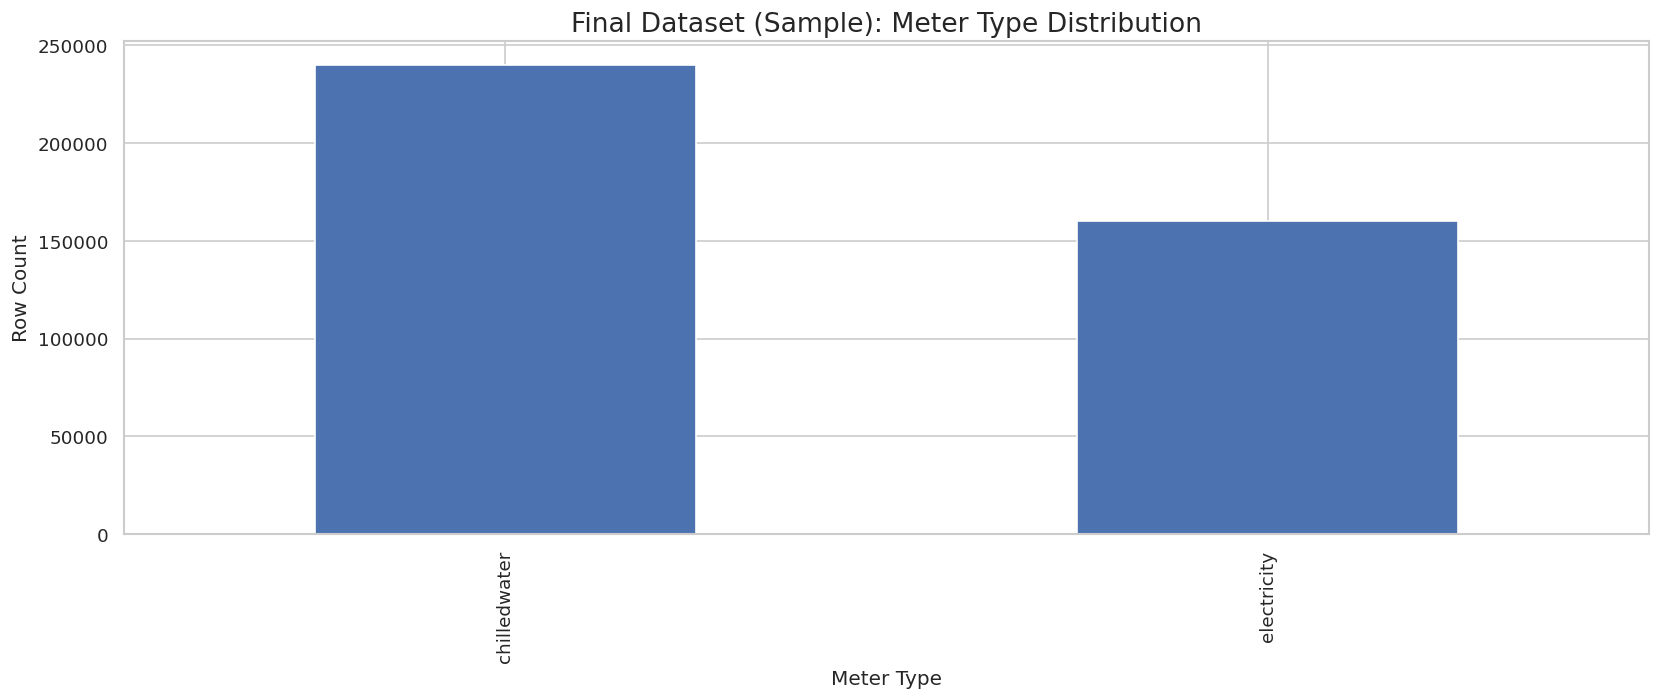


📌 Missing Values % (Top 15 Columns)
primaryspaceusage    1.04875
timestamp            0.00000
value                0.00000
building_id          0.00000
meter_type           0.00000
site_id              0.00000
sqm                  0.00000
sqft                 0.00000
timezone             0.00000
airTemperature       0.00000
dewTemperature       0.00000
windSpeed            0.00000
windDirection        0.00000
cloudCoverage        0.00000
precipDepth1HR       0.00000
dtype: float64
✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/FINAL_EDA_02_missing_values.png


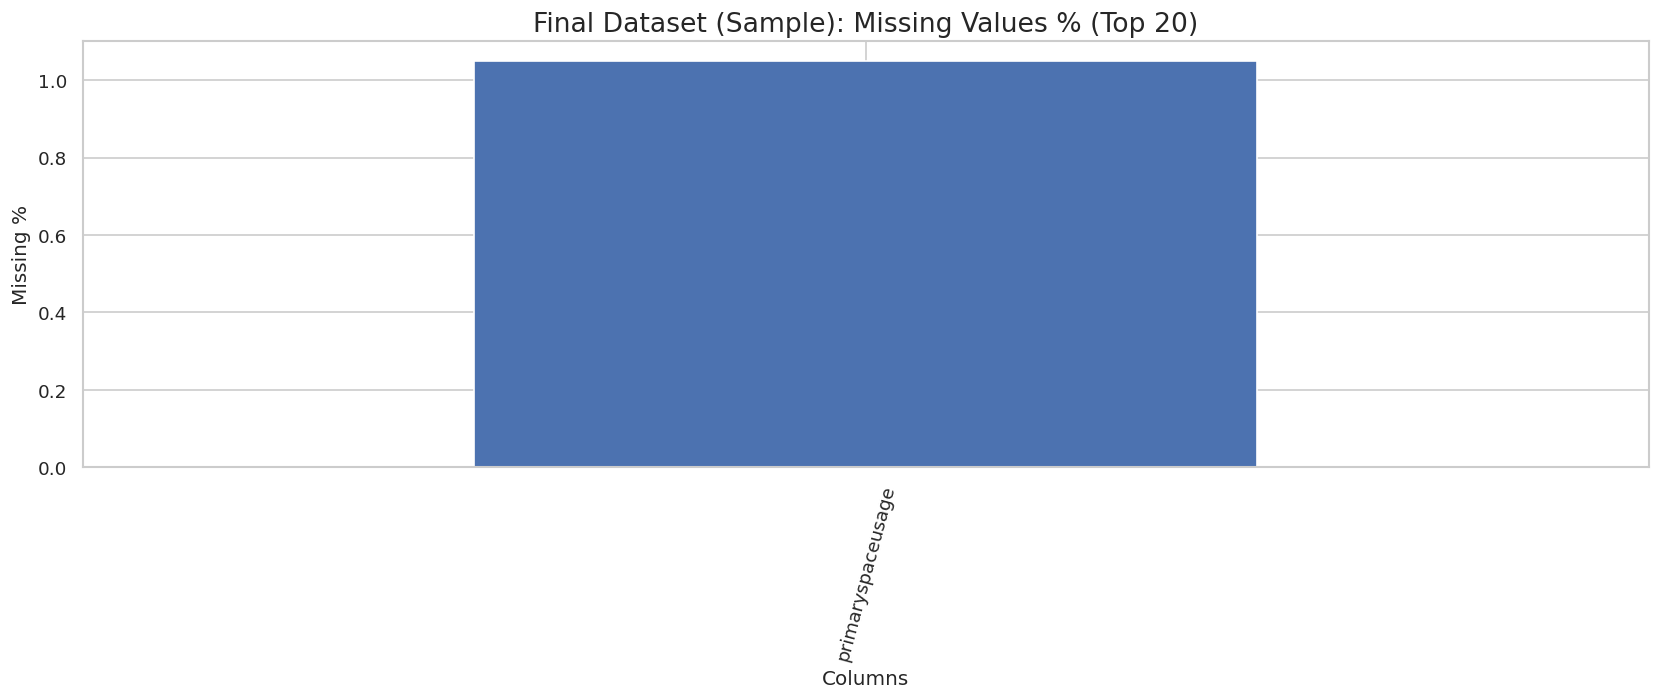

✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/FINAL_EDA_03_value_distribution.png


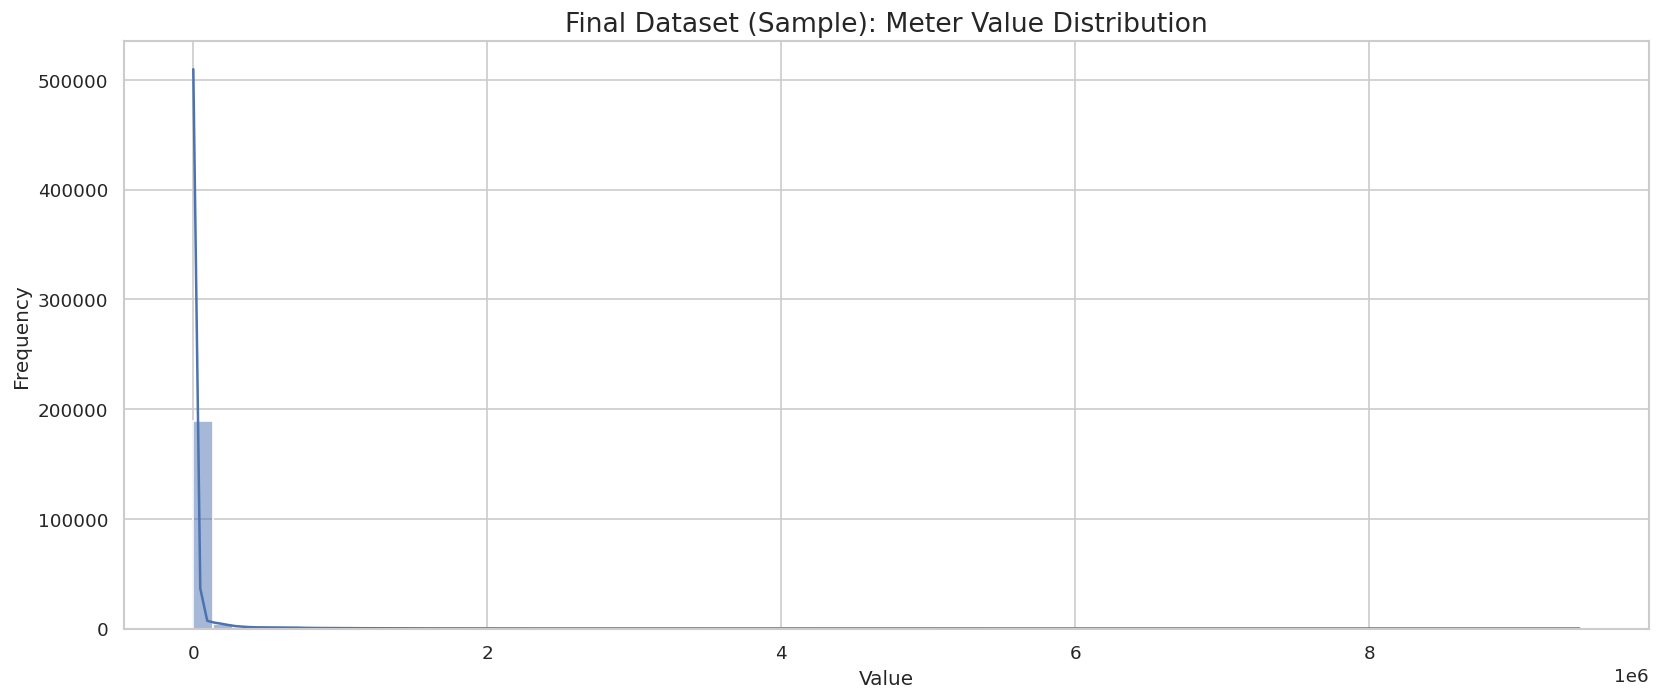

✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/FINAL_EDA_04_value_distribution_log.png


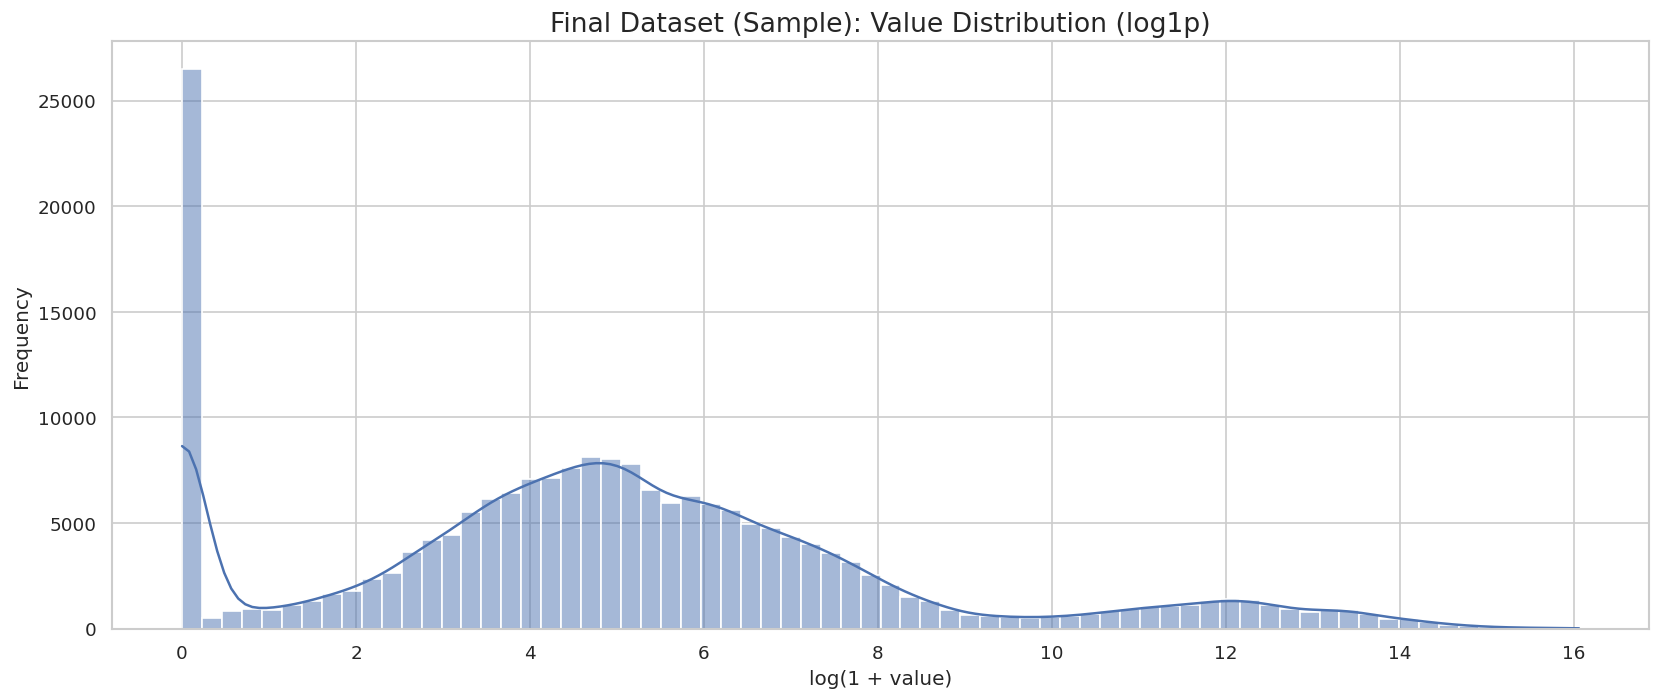

✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/FINAL_EDA_05_electricity_daily_trend.png


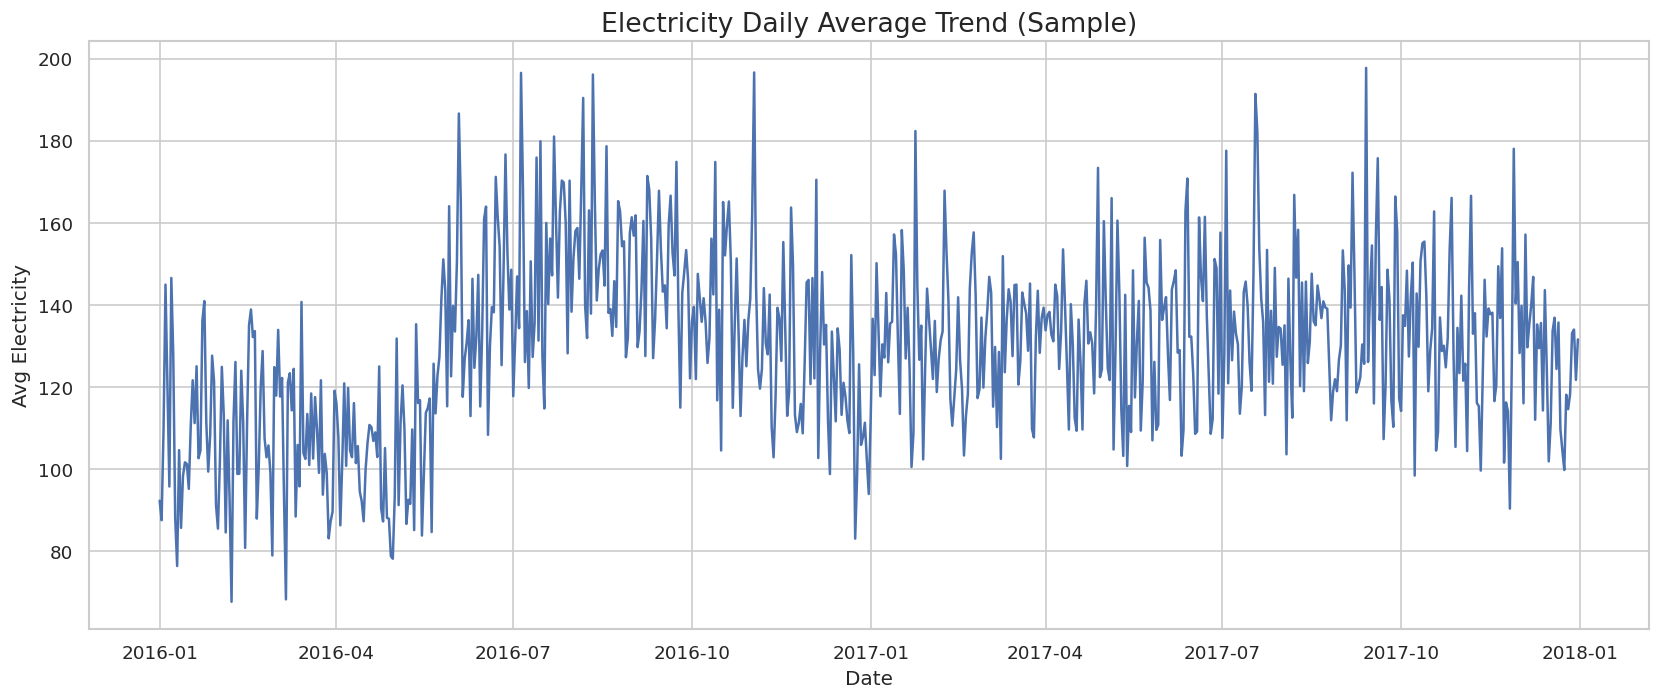

✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/FINAL_EDA_06_weather_correlation_heatmap.png


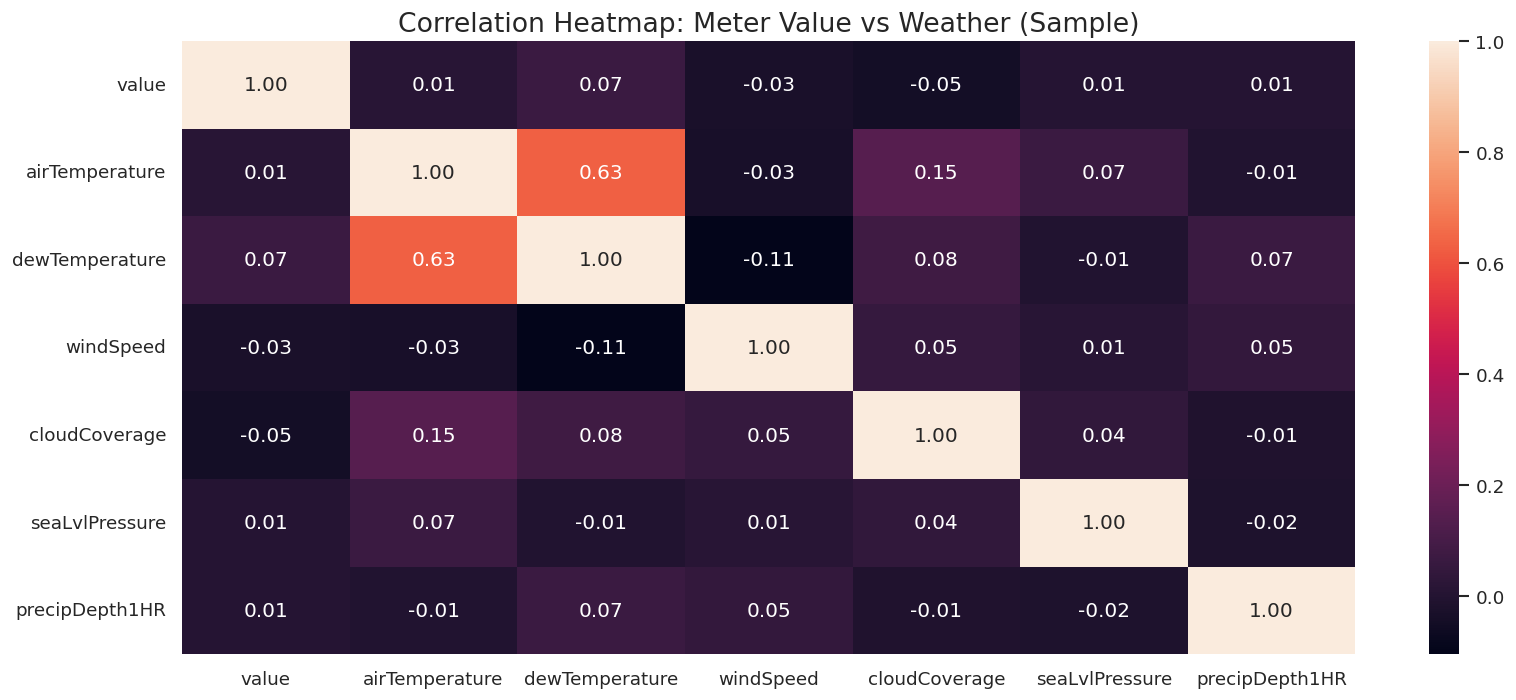

✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/FINAL_EDA_07_top10_buildings_avg_electricity.png


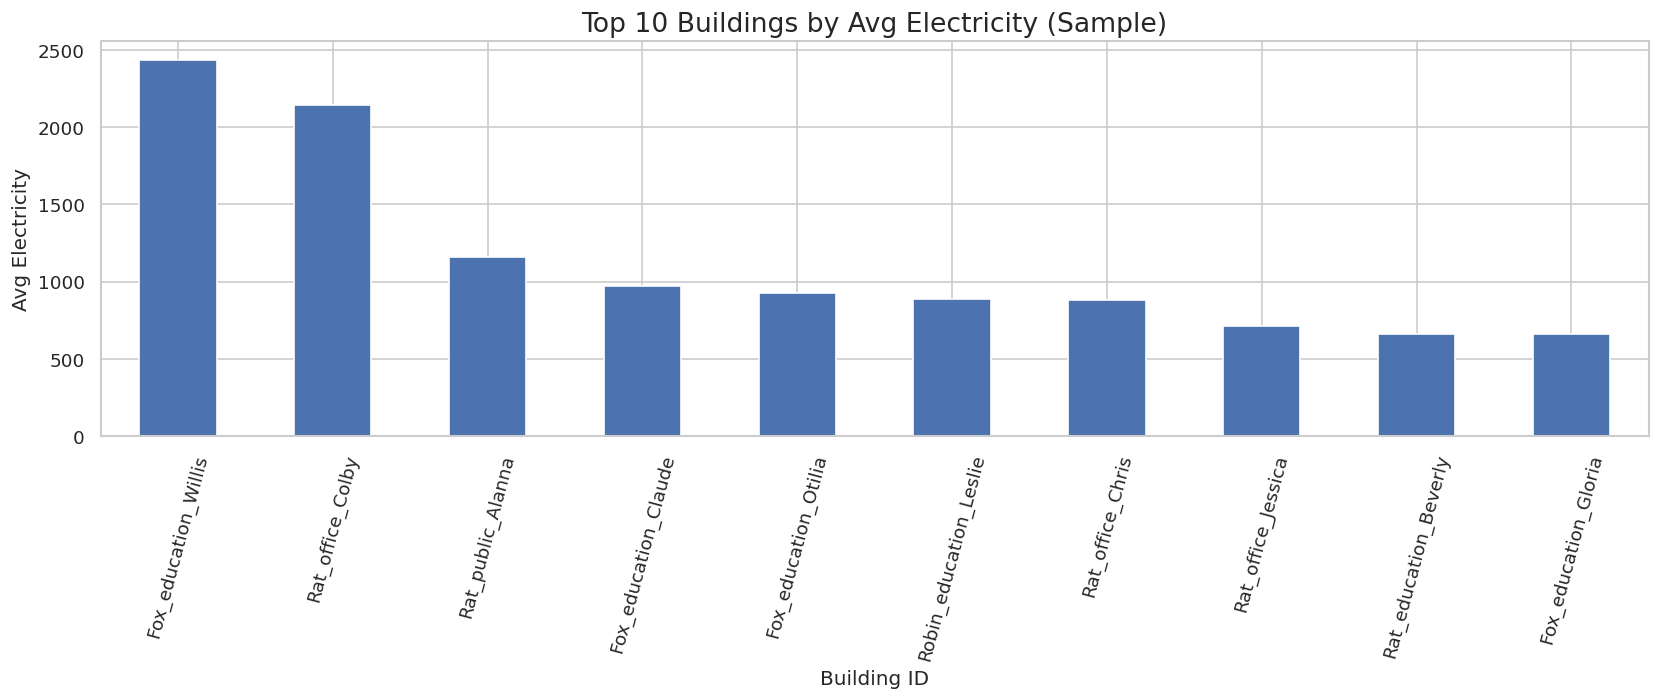


✅ FINAL DATASET EDA COMPLETED ✅
✅ Plots saved into: /content/bdg2_energy_anomaly_detection/plots
✅ NEXT STEP: Run CELL 9 for Feature Engineering + Model Training


In [9]:
# =========================================================
# CELL 8 (FIXED): EDA of FINAL MERGED PREPROCESSED DATASET
# =========================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

FINAL_PATH = os.path.join(DIRS["processed"], "final_preprocessed_dataset.csv")

if not os.path.exists(FINAL_PATH):
    raise FileNotFoundError(f"❌ Not found: {FINAL_PATH}")

print("✅ Found final dataset:", FINAL_PATH)
print("⏳ Loading sample safely from final dataset...")

SAMPLE_ROWS = 400000
df = pd.read_csv(FINAL_PATH, nrows=SAMPLE_ROWS)

print("\n✅ Sample Loaded")
print("✅ Sample Shape:", df.shape)
print("✅ Columns:", df.columns.tolist())

df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"])

print("\n📌 BASIC SUMMARY (Sample Based)")
print("Date Range:", df["timestamp"].min(), "→", df["timestamp"].max())
print("Unique buildings:", df["building_id"].nunique() if "building_id" in df.columns else "NA")
print("Unique sites:", df["site_id"].nunique() if "site_id" in df.columns else "NA")
print("Meter types:", df["meter_type"].nunique() if "meter_type" in df.columns else "NA")
print("Meter types list:", df["meter_type"].unique()[:10] if "meter_type" in df.columns else "NA")

# -----------------------------
# Plot 1: Meter type distribution
# -----------------------------
if "meter_type" in df.columns:
    fig = plt.figure()
    df["meter_type"].value_counts().plot(kind="bar")
    plt.title("Final Dataset (Sample): Meter Type Distribution")
    plt.xlabel("Meter Type")
    plt.ylabel("Row Count")
    save_plot(fig, "FINAL_EDA_01_meter_type_distribution.png")
    plt.show()

# -----------------------------
# Plot 2: Missing values %
# -----------------------------
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)

print("\n📌 Missing Values % (Top 15 Columns)")
print(missing_pct.head(15))

missing_nonzero = missing_pct[missing_pct > 0]

if len(missing_nonzero) == 0:
    print("\n✅ No missing values found in the sample → skipping missing-values plot ✅")
else:
    fig = plt.figure()
    missing_nonzero.head(20).plot(kind="bar")
    plt.title("Final Dataset (Sample): Missing Values % (Top 20)")
    plt.xlabel("Columns")
    plt.ylabel("Missing %")
    plt.xticks(rotation=75)
    save_plot(fig, "FINAL_EDA_02_missing_values.png")
    plt.show()

# -----------------------------
# Plot 3: Value distribution
# -----------------------------
if "value" in df.columns:
    value_sample = df["value"].dropna()
    if len(value_sample) > 200000:
        value_sample = value_sample.sample(200000, random_state=42)

    fig = plt.figure()
    sns.histplot(value_sample, bins=70, kde=True)
    plt.title("Final Dataset (Sample): Meter Value Distribution")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    save_plot(fig, "FINAL_EDA_03_value_distribution.png")
    plt.show()

    fig = plt.figure()
    sns.histplot(np.log1p(value_sample), bins=70, kde=True)
    plt.title("Final Dataset (Sample): Value Distribution (log1p)")
    plt.xlabel("log(1 + value)")
    plt.ylabel("Frequency")
    save_plot(fig, "FINAL_EDA_04_value_distribution_log.png")
    plt.show()

# -----------------------------
# Plot 4: Electricity daily trend (if electricity exists)
# -----------------------------
if "meter_type" in df.columns and "value" in df.columns:
    elec = df[df["meter_type"] == "electricity"].copy()
    if len(elec) > 0:
        elec["date"] = elec["timestamp"].dt.date
        daily_avg = elec.groupby("date")["value"].mean().reset_index()

        fig = plt.figure()
        plt.plot(pd.to_datetime(daily_avg["date"]), daily_avg["value"])
        plt.title("Electricity Daily Average Trend (Sample)")
        plt.xlabel("Date")
        plt.ylabel("Avg Electricity")
        save_plot(fig, "FINAL_EDA_05_electricity_daily_trend.png")
        plt.show()

# -----------------------------
# Plot 5: Weather correlation heatmap
# -----------------------------
weather_cols = [c for c in [
    "airTemperature", "dewTemperature", "windSpeed",
    "cloudCoverage", "seaLvlPressure", "precipDepth1HR"
] if c in df.columns]

if "value" in df.columns and len(weather_cols) >= 2:
    corr_df = df[["value"] + weather_cols].select_dtypes(include=[np.number]).dropna()
    if len(corr_df) > 100000:
        corr_df = corr_df.sample(100000, random_state=42)

    fig = plt.figure()
    sns.heatmap(corr_df.corr(), annot=True, fmt=".2f")
    plt.title("Correlation Heatmap: Meter Value vs Weather (Sample)")
    save_plot(fig, "FINAL_EDA_06_weather_correlation_heatmap.png")
    plt.show()

# -----------------------------
# Plot 6: Top 10 buildings by avg electricity
# -----------------------------
if "building_id" in df.columns and "meter_type" in df.columns and "value" in df.columns:
    elec = df[df["meter_type"] == "electricity"].copy()
    if len(elec) > 0:
        top10 = elec.groupby("building_id")["value"].mean().sort_values(ascending=False).head(10)

        fig = plt.figure()
        top10.plot(kind="bar")
        plt.title("Top 10 Buildings by Avg Electricity (Sample)")
        plt.xlabel("Building ID")
        plt.ylabel("Avg Electricity")
        plt.xticks(rotation=75)
        save_plot(fig, "FINAL_EDA_07_top10_buildings_avg_electricity.png")
        plt.show()

print("\n✅ FINAL DATASET EDA COMPLETED ✅")
print("✅ Plots saved into:", DIRS["plots"])
print("✅ NEXT STEP: Run CELL 9 for Feature Engineering + Model Training")


✅ Loading final dataset (sample for safe training)...
✅ Loaded shape: (800000, 20)
✅ Filtered to electricity only for training: (560000, 20)
✅ Feature engineering done. Columns now: 25
✅ Model features used: ['value', 'value_rolling_mean', 'value_rolling_std', 'value_deviation', 'value_lag1', 'value_lag24', 'airTemperature', 'dewTemperature', 'windSpeed', 'hour', 'day_of_week', 'month', 'is_weekend']
✅ X shape: (560000, 13)

⏳ Training Isolation Forest...
⏳ Training LOF (novelty=True)...
⏳ Training Robust Covariance (EllipticEnvelope)...

✅ Anomaly Rate (Ensemble): 3.60%

✅ Models saved into: /content/bdg2_energy_anomaly_detection/models
✅ Predictions saved: /content/bdg2_energy_anomaly_detection/outputs/anomaly_predictions.csv
✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/MODEL_01_anomaly_distribution.png


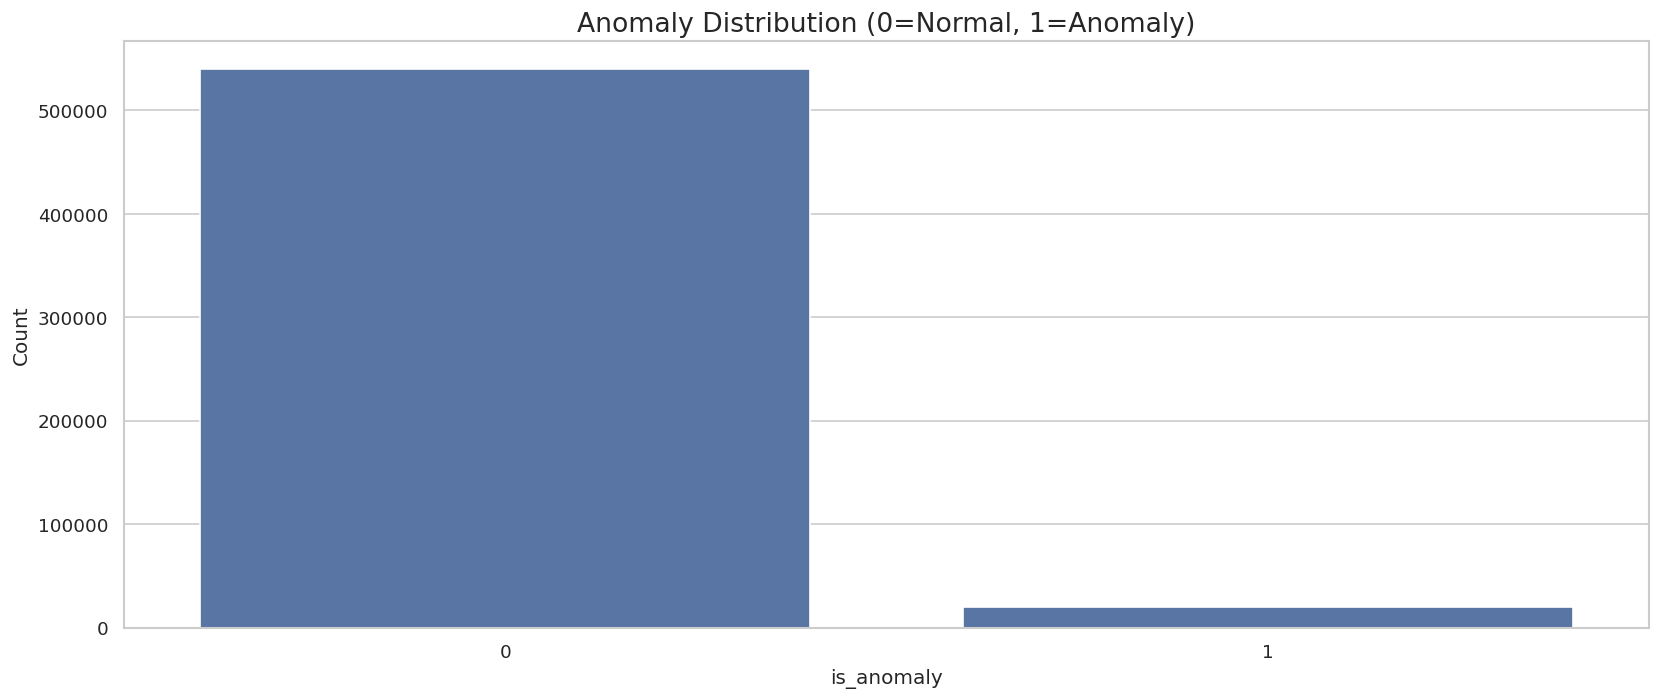

✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/MODEL_02_deviation_distribution.png


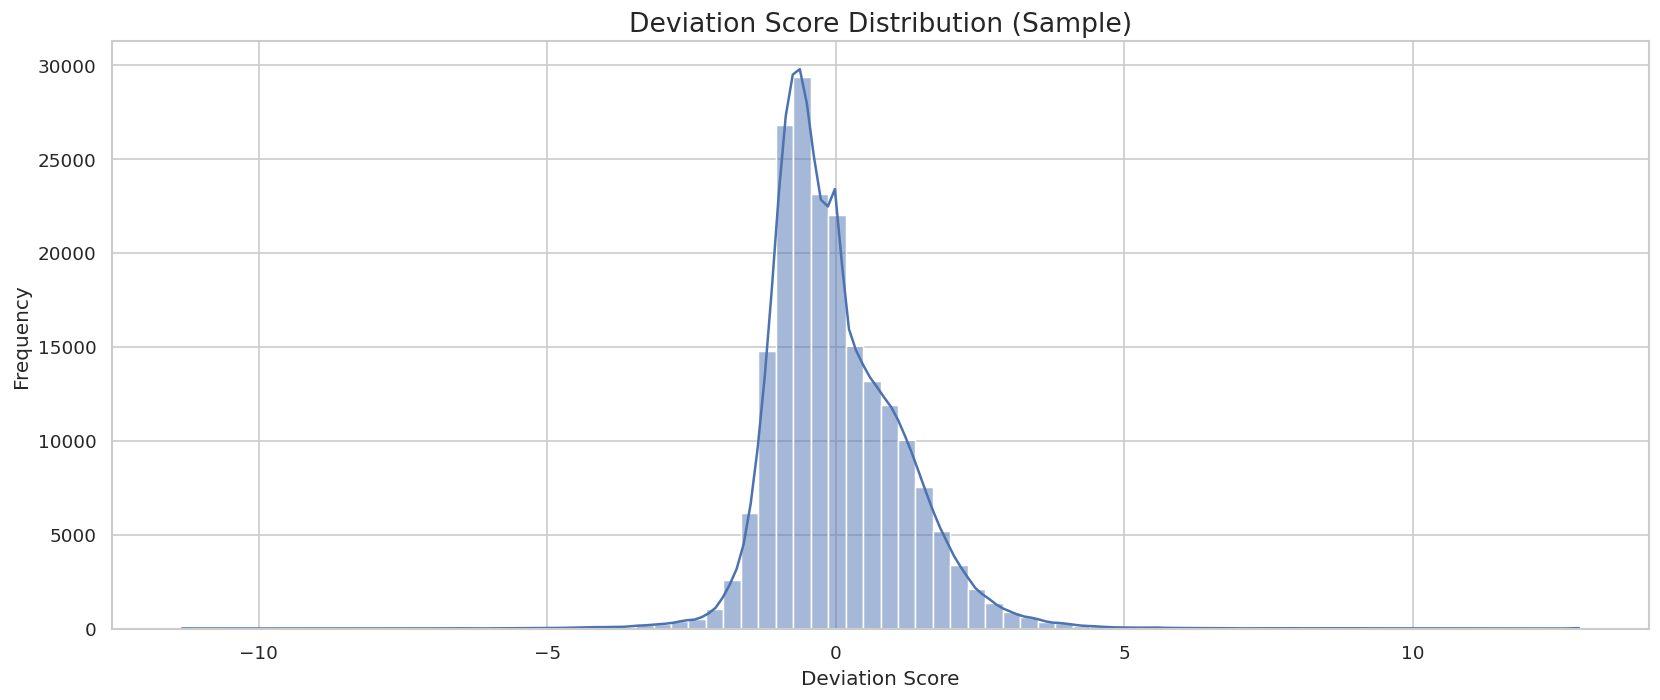

✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/MODEL_03_anomaly_timeseries_sample_building.png


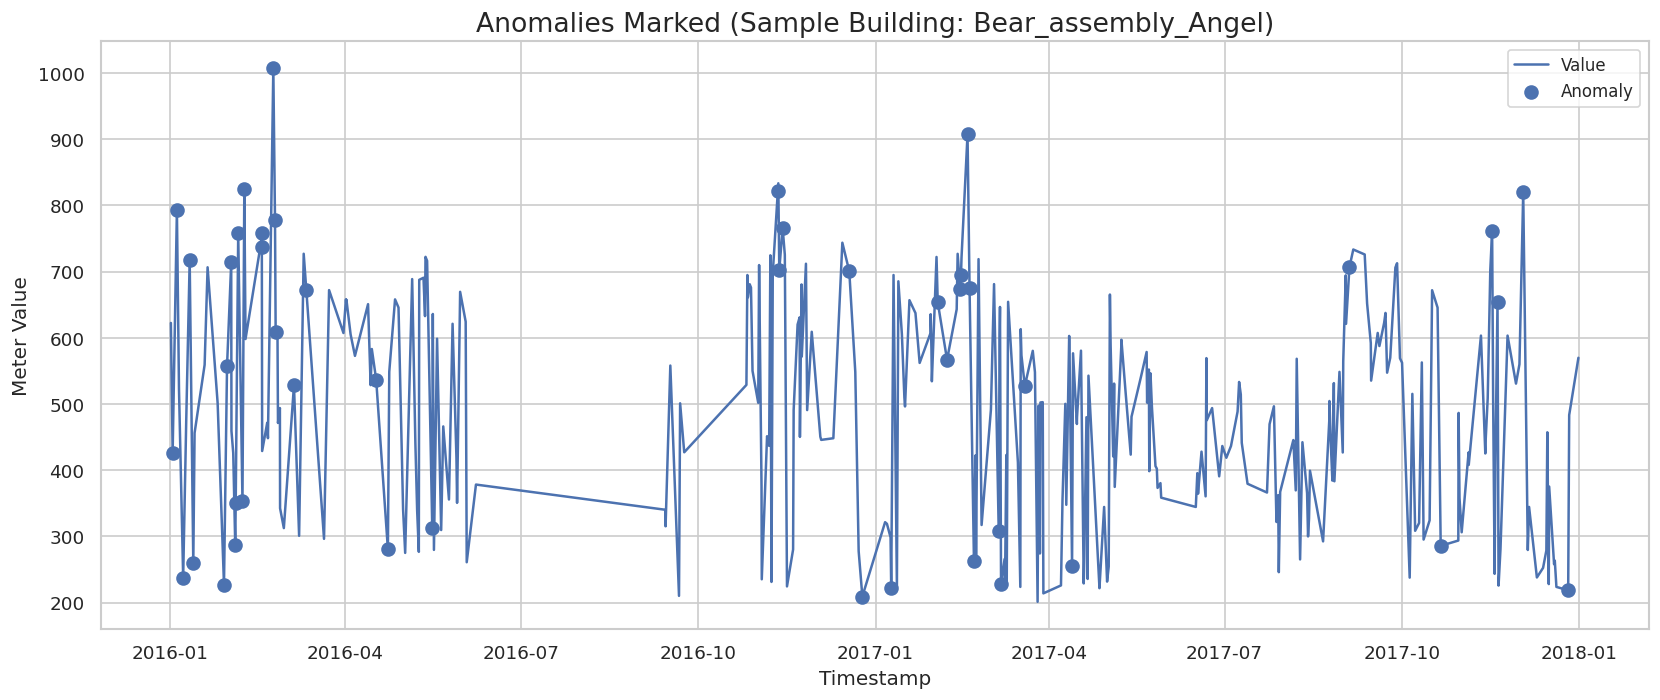

✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/MODEL_04_feature_correlation_heatmap.png


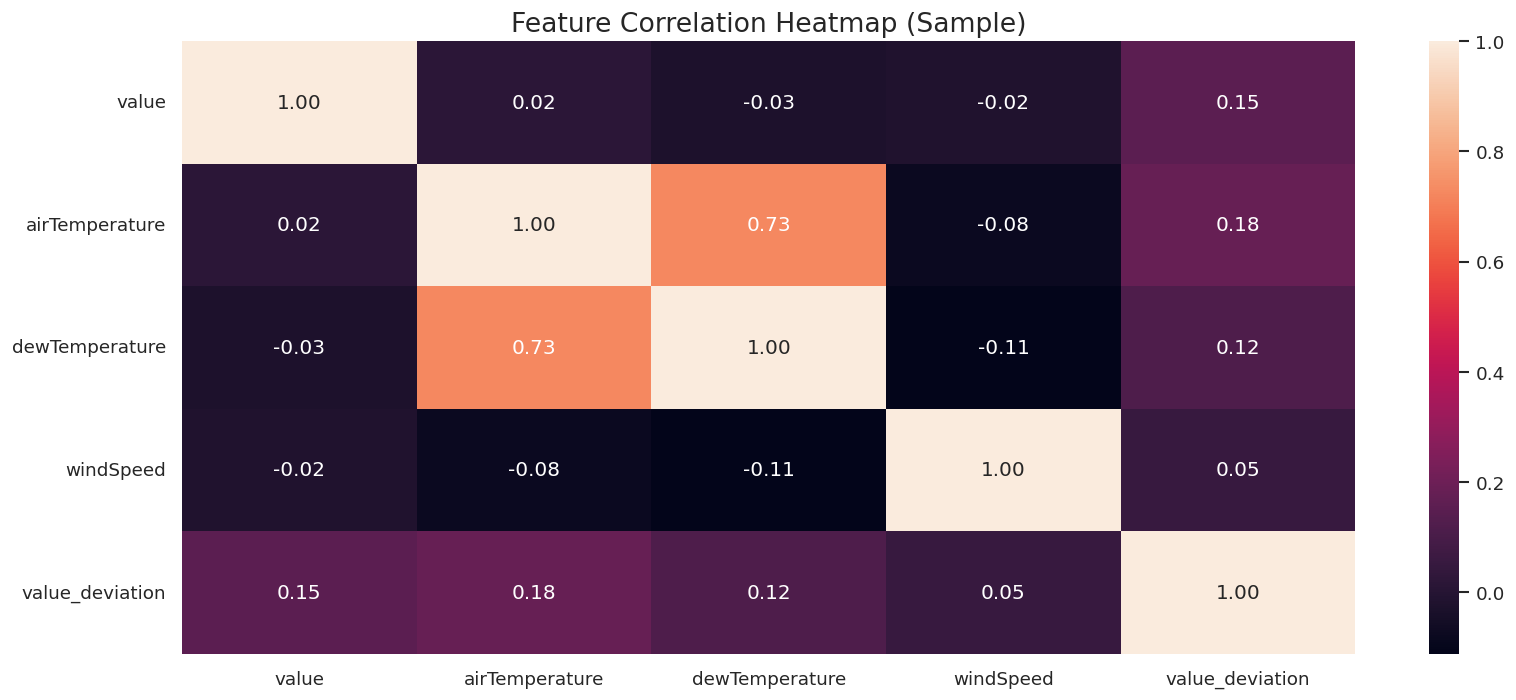


✅ CELL 9 COMPLETE ✅
✅ NEXT STEP: Run CELL 10 for Business Insights + Cost Impact + Peak Hours + Seasonal patterns


In [10]:
# =========================================================
# CELL 9: Feature Engineering + Train + Evaluate + Save
# =========================================================

import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

FINAL_PATH = os.path.join(DIRS["processed"], "final_preprocessed_dataset.csv")

if not os.path.exists(FINAL_PATH):
    raise FileNotFoundError(f"❌ Final dataset not found: {FINAL_PATH}")

print("✅ Loading final dataset (sample for safe training)...")

# ✅ Training sample size (tune this safely)
TRAIN_ROWS = 800000   # set 400000 if runtime slow
df = pd.read_csv(FINAL_PATH, nrows=TRAIN_ROWS)

print("✅ Loaded shape:", df.shape)

# -----------------------------
# Data typing + sorting
# -----------------------------
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"])

# If meter types are multiple, we focus on electricity for robust training
if "meter_type" in df.columns:
    if (df["meter_type"].nunique() > 1) and ("electricity" in df["meter_type"].unique()):
        df = df[df["meter_type"] == "electricity"].copy()
        print("✅ Filtered to electricity only for training:", df.shape)

df = df.sort_values(["building_id", "timestamp"]).reset_index(drop=True)

# -----------------------------
# Feature Engineering (Rolling + Lags)
# -----------------------------
WINDOW = 168  # 7 days

df["value_rolling_mean"] = (
    df.groupby("building_id")["value"]
    .transform(lambda s: s.rolling(window=WINDOW, min_periods=24).mean())
)

df["value_rolling_std"] = (
    df.groupby("building_id")["value"]
    .transform(lambda s: s.rolling(window=WINDOW, min_periods=24).std())
)

df["value_rolling_std"] = df["value_rolling_std"].fillna(0)

df["value_deviation"] = (df["value"] - df["value_rolling_mean"]) / (df["value_rolling_std"] + 1e-5)

df["value_lag1"] = df.groupby("building_id")["value"].shift(1)
df["value_lag24"] = df.groupby("building_id")["value"].shift(24)

# Fill engineered NaNs
fill_cols = ["value_rolling_mean", "value_rolling_std", "value_deviation", "value_lag1", "value_lag24"]
df[fill_cols] = df[fill_cols].ffill().bfill()

print("✅ Feature engineering done. Columns now:", df.shape[1])

# -----------------------------
# Model Feature Set (as per doc)
# -----------------------------
features = [
    "value",
    "value_rolling_mean",
    "value_rolling_std",
    "value_deviation",
    "value_lag1",
    "value_lag24",
    "airTemperature",
    "dewTemperature",
    "windSpeed",
    "hour",
    "day_of_week",
    "month",
    "is_weekend"
]

# keep only available columns
features = [c for c in features if c in df.columns]
X = df[features].copy()

# Fill any missing numeric
X = X.select_dtypes(include=[np.number]).fillna(0)

print("✅ Model features used:", features)
print("✅ X shape:", X.shape)

# -----------------------------
# Scaling (RobustScaler is best for anomalies)
# -----------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# Train models
# -----------------------------
contamination = CONFIG.get("contamination", 0.05)

print("\n⏳ Training Isolation Forest...")
iso = IsolationForest(
    n_estimators=200,
    contamination=contamination,
    random_state=CONFIG.get("random_state", 42),
    n_jobs=-1
)
iso.fit(X_scaled)
pred_iso = iso.predict(X_scaled)

print("⏳ Training LOF (novelty=True)...")
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=contamination,
    novelty=True
)
lof.fit(X_scaled)
pred_lof = lof.predict(X_scaled)

print("⏳ Training Robust Covariance (EllipticEnvelope)...")
rob = EllipticEnvelope(
    contamination=contamination,
    random_state=CONFIG.get("random_state", 42)
)
rob.fit(X_scaled)
pred_rob = rob.predict(X_scaled)

# -----------------------------
# Ensemble Voting
# -----------------------------
df["anomaly_votes"] = (pred_iso == -1).astype(int) + (pred_lof == -1).astype(int) + (pred_rob == -1).astype(int)
df["is_anomaly"] = (df["anomaly_votes"] >= 2).astype(int)

anomaly_rate = df["is_anomaly"].mean() * 100
print(f"\n✅ Anomaly Rate (Ensemble): {anomaly_rate:.2f}%")

# -----------------------------
# Save models
# -----------------------------
joblib.dump(scaler, os.path.join(DIRS["models"], "scaler.pkl"))
joblib.dump(iso, os.path.join(DIRS["models"], "isolation_forest.pkl"))
joblib.dump(lof, os.path.join(DIRS["models"], "lof_model.pkl"))
joblib.dump(rob, os.path.join(DIRS["models"], "robust_cov.pkl"))

joblib.dump(features, os.path.join(DIRS["models"], "feature_list.pkl"))

print("\n✅ Models saved into:", DIRS["models"])

# -----------------------------
# Save predictions output
# -----------------------------
out_pred = df[["timestamp", "building_id", "site_id", "value", "airTemperature", "is_anomaly", "anomaly_votes"]].copy()
out_path = os.path.join(DIRS["outputs"], "anomaly_predictions.csv")
out_pred.to_csv(out_path, index=False)

print("✅ Predictions saved:", out_path)

# -----------------------------
# Evaluation Plots
# -----------------------------

# Plot 1: Anomaly distribution
fig = plt.figure()
sns.countplot(x=df["is_anomaly"])
plt.title("Anomaly Distribution (0=Normal, 1=Anomaly)")
plt.xlabel("is_anomaly")
plt.ylabel("Count")
save_plot(fig, "MODEL_01_anomaly_distribution.png")
plt.show()

# Plot 2: Deviation distribution
fig = plt.figure()
sns.histplot(df["value_deviation"].dropna().sample(min(200000, len(df)), random_state=42), bins=80, kde=True)
plt.title("Deviation Score Distribution (Sample)")
plt.xlabel("Deviation Score")
plt.ylabel("Frequency")
save_plot(fig, "MODEL_02_deviation_distribution.png")
plt.show()

# Plot 3: Time series anomaly markers (single building sample)
sample_building = df["building_id"].dropna().unique()[0]
sample_ts = df[df["building_id"] == sample_building].iloc[:1000].copy()
anom_ts = sample_ts[sample_ts["is_anomaly"] == 1]

fig = plt.figure()
plt.plot(sample_ts["timestamp"], sample_ts["value"], label="Value")
plt.scatter(anom_ts["timestamp"], anom_ts["value"], s=60, label="Anomaly")
plt.title(f"Anomalies Marked (Sample Building: {sample_building})")
plt.xlabel("Timestamp")
plt.ylabel("Meter Value")
plt.legend()
save_plot(fig, "MODEL_03_anomaly_timeseries_sample_building.png")
plt.show()

# Plot 4: Correlation heatmap (compact)
corr_cols = [c for c in ["value", "airTemperature", "dewTemperature", "windSpeed", "value_deviation"] if c in df.columns]
corr_df = df[corr_cols].select_dtypes(include=[np.number]).dropna()

if len(corr_df) > 80000:
    corr_df = corr_df.sample(80000, random_state=42)

fig = plt.figure()
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f")
plt.title("Feature Correlation Heatmap (Sample)")
save_plot(fig, "MODEL_04_feature_correlation_heatmap.png")
plt.show()

print("\n✅ CELL 9 COMPLETE ✅")
print("✅ NEXT STEP: Run CELL 10 for Business Insights + Cost Impact + Peak Hours + Seasonal patterns")


✅ Loaded predictions: (560000, 7)

📌 MODEL OUTPUT SUMMARY
Total Records Processed : 560,000
Total Anomalies Found   : 20,140
Anomaly Rate (%)        : 3.60%

💰 Estimated cost impact of anomalies (approx): $2,476,086.02
✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/INSIGHTS_01_anomalies_by_month.png


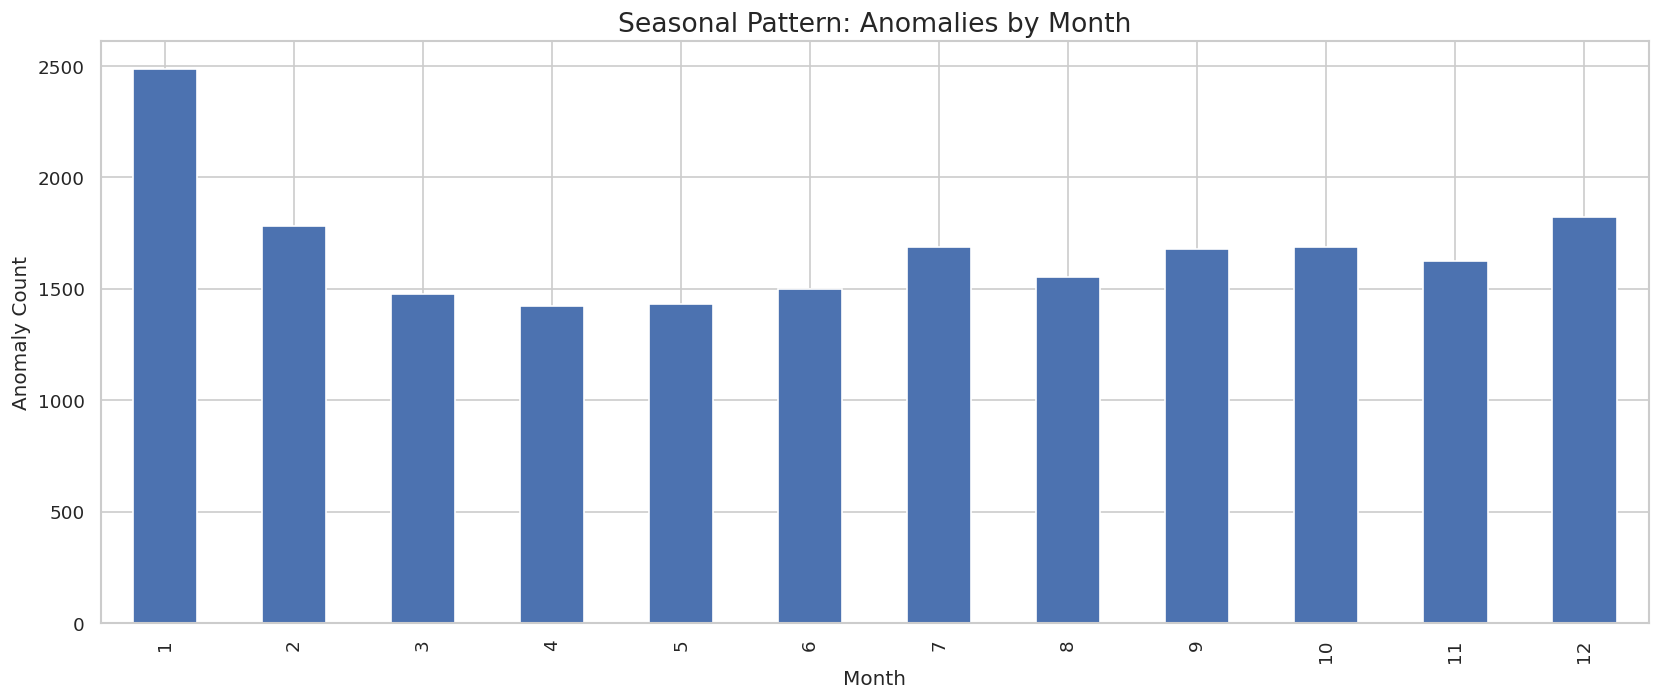

✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/INSIGHTS_02_anomalies_by_hour.png


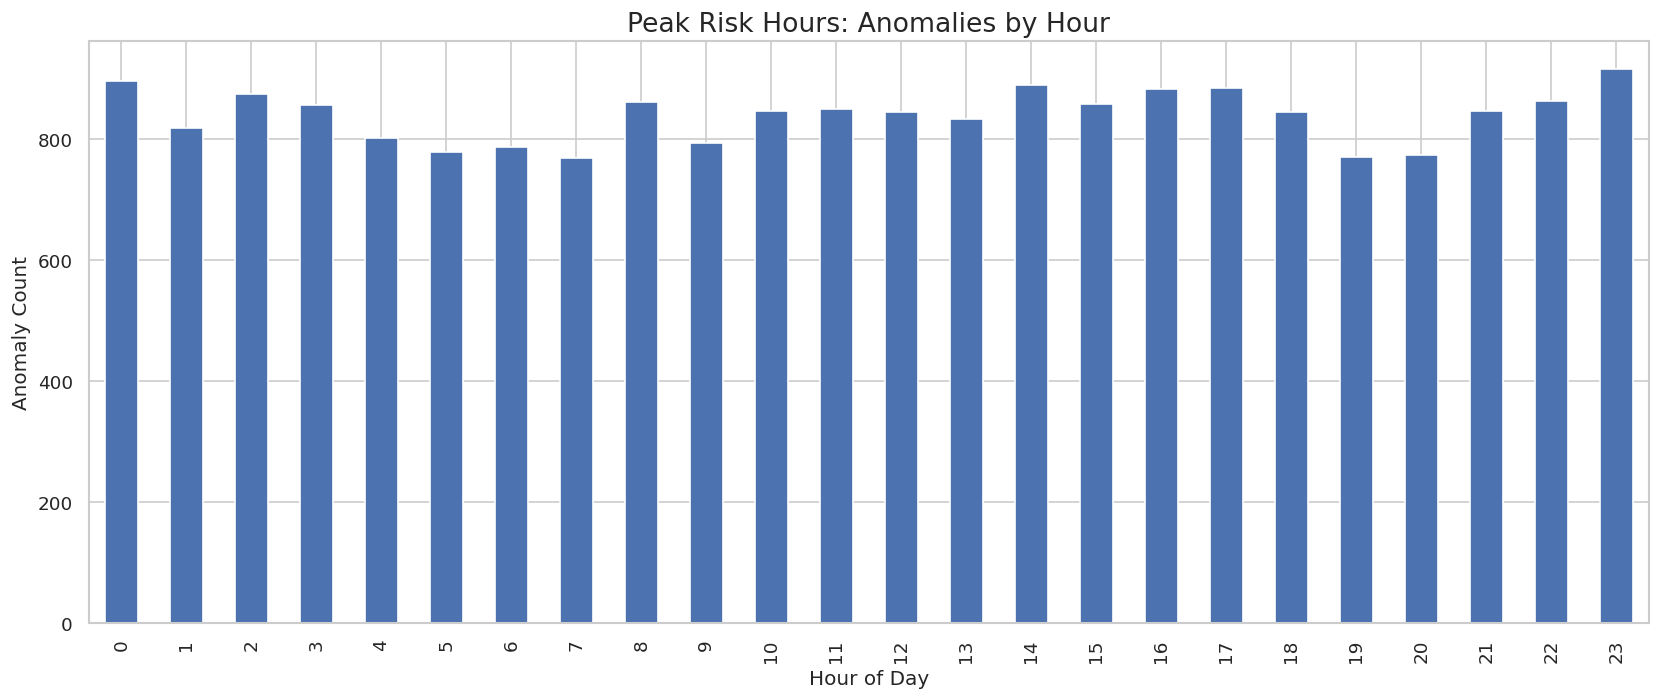


📌 Top 10 peak anomaly hours:
hour
23    916
0     896
14    890
17    885
16    883
2     875
22    863
8     861
15    858
3     857
dtype: int64
✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/INSIGHTS_03_top_buildings_by_anomalies.png


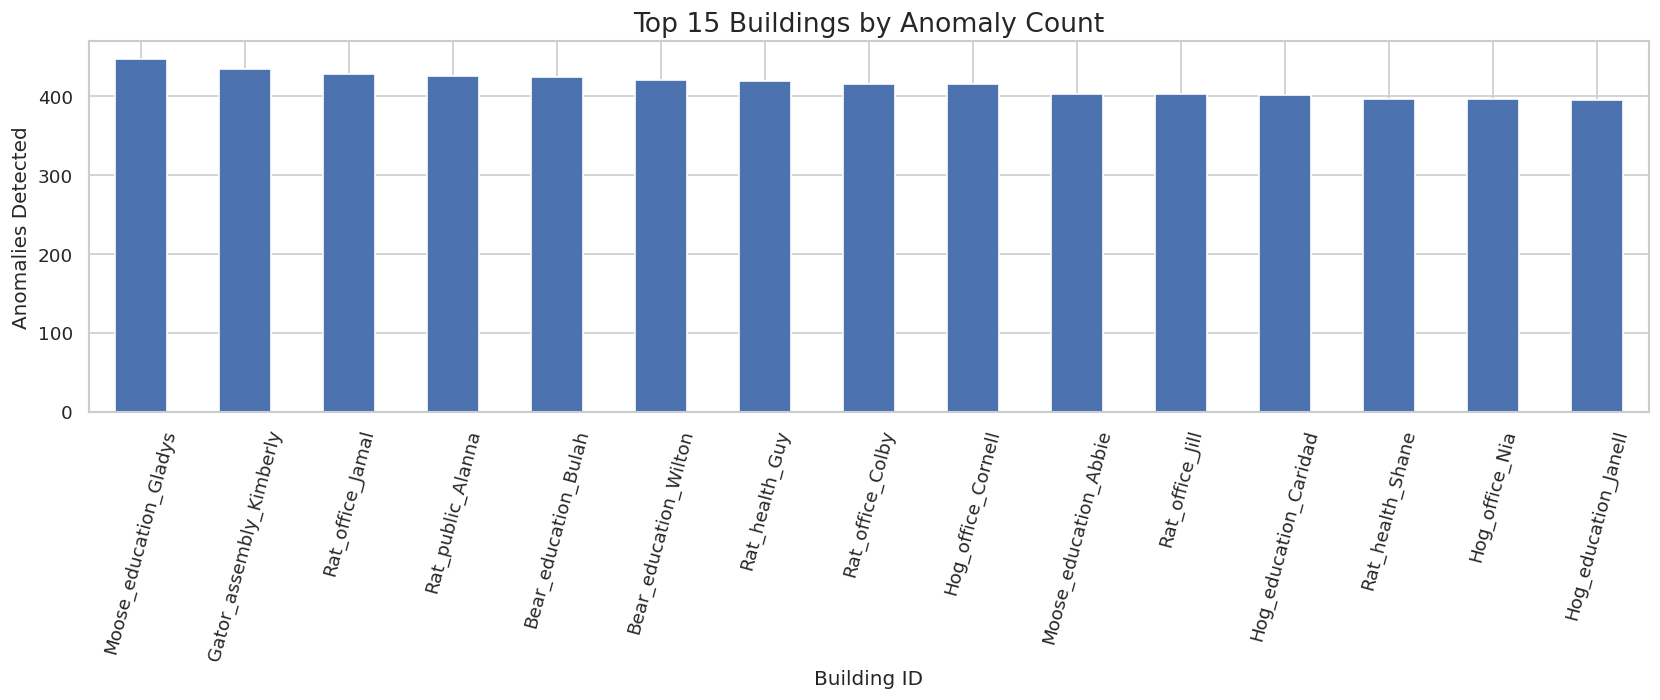


✅ Saved: /content/bdg2_energy_anomaly_detection/outputs/top_anomalous_buildings.csv
✅ Plot saved: /content/bdg2_energy_anomaly_detection/plots/INSIGHTS_04_anomaly_type_breakdown.png


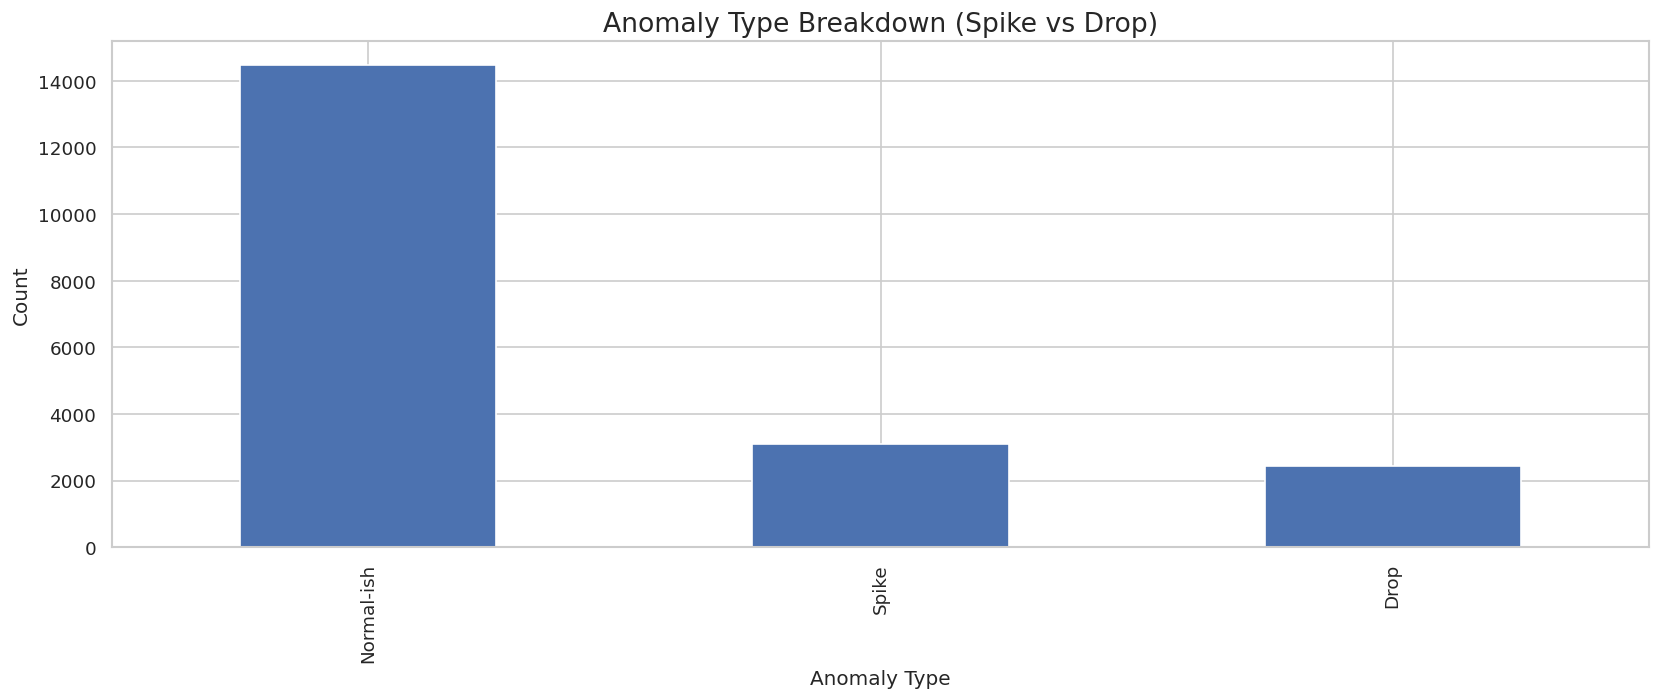


📌 Anomaly type breakdown:
anomaly_type
Normal-ish    14466
Spike          3109
Drop           2440
Name: count, dtype: int64

✅ Business Insights Report Saved: /content/bdg2_energy_anomaly_detection/reports/business_insights_summary.txt
✅ CELL 10 COMPLETE ✅


In [11]:
# =========================================================
# CELL 10: Business Insights + Impact Analysis (Industry Grade)
# =========================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PRED_PATH = os.path.join(DIRS["outputs"], "anomaly_predictions.csv")

if not os.path.exists(PRED_PATH):
    raise FileNotFoundError(f"❌ Missing predictions file: {PRED_PATH}. Run CELL 9 first.")

df = pd.read_csv(PRED_PATH)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"])

print("✅ Loaded predictions:", df.shape)

# ---------------------------------------------------------
# Core Summary Metrics
# ---------------------------------------------------------
total_rows = len(df)
total_anomalies = int(df["is_anomaly"].sum())
anom_rate = (total_anomalies / total_rows) * 100

print("\n📌 MODEL OUTPUT SUMMARY")
print(f"Total Records Processed : {total_rows:,}")
print(f"Total Anomalies Found   : {total_anomalies:,}")
print(f"Anomaly Rate (%)        : {anom_rate:.2f}%")

# ---------------------------------------------------------
# Cost Impact Estimation
# ---------------------------------------------------------
# Business assumption: avg electricity price per kWh (adjustable)
AVG_KWH_COST = 0.12

anomaly_df = df[df["is_anomaly"] == 1].copy()

estimated_cost = anomaly_df["value"].sum() * AVG_KWH_COST
print(f"\n💰 Estimated cost impact of anomalies (approx): ${estimated_cost:,.2f}")

# ---------------------------------------------------------
# Seasonal Pattern (Month)
# ---------------------------------------------------------
anomaly_df["month"] = anomaly_df["timestamp"].dt.month
monthly_counts = anomaly_df.groupby("month").size()

fig = plt.figure()
monthly_counts.plot(kind="bar")
plt.title("Seasonal Pattern: Anomalies by Month")
plt.xlabel("Month")
plt.ylabel("Anomaly Count")
save_plot(fig, "INSIGHTS_01_anomalies_by_month.png")
plt.show()

# ---------------------------------------------------------
# Peak Hours (Hour of Day)
# ---------------------------------------------------------
anomaly_df["hour"] = anomaly_df["timestamp"].dt.hour
hourly_counts = anomaly_df.groupby("hour").size().sort_values(ascending=False)

fig = plt.figure()
hourly_counts.sort_index().plot(kind="bar")
plt.title("Peak Risk Hours: Anomalies by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Anomaly Count")
save_plot(fig, "INSIGHTS_02_anomalies_by_hour.png")
plt.show()

print("\n📌 Top 10 peak anomaly hours:")
print(hourly_counts.head(10))

# ---------------------------------------------------------
# Top Anomalous Buildings
# ---------------------------------------------------------
top_buildings = (
    anomaly_df.groupby("building_id")
    .size()
    .sort_values(ascending=False)
    .head(15)
)

fig = plt.figure()
top_buildings.plot(kind="bar")
plt.title("Top 15 Buildings by Anomaly Count")
plt.xlabel("Building ID")
plt.ylabel("Anomalies Detected")
plt.xticks(rotation=75)
save_plot(fig, "INSIGHTS_03_top_buildings_by_anomalies.png")
plt.show()

top_buildings_df = top_buildings.reset_index()
top_buildings_df.columns = ["building_id", "anomaly_count"]

top_buildings_path = os.path.join(DIRS["outputs"], "top_anomalous_buildings.csv")
top_buildings_df.to_csv(top_buildings_path, index=False)

print(f"\n✅ Saved: {top_buildings_path}")

# ---------------------------------------------------------
# Spike vs Drop classification using deviation proxy
# (If deviation not in anomaly_predictions, approximate using percent jump)
# ---------------------------------------------------------
df_sorted = df.sort_values(["building_id", "timestamp"]).copy()
df_sorted["prev_value"] = df_sorted.groupby("building_id")["value"].shift(1)
df_sorted["pct_change"] = (df_sorted["value"] - df_sorted["prev_value"]) / (df_sorted["prev_value"] + 1e-5)

anom_sorted = df_sorted[df_sorted["is_anomaly"] == 1].copy()

anom_sorted["anomaly_type"] = pd.cut(
    anom_sorted["pct_change"],
    bins=[-np.inf, -0.30, 0.30, np.inf],
    labels=["Drop", "Normal-ish", "Spike"]
)

type_counts = anom_sorted["anomaly_type"].value_counts()

fig = plt.figure()
type_counts.plot(kind="bar")
plt.title("Anomaly Type Breakdown (Spike vs Drop)")
plt.xlabel("Anomaly Type")
plt.ylabel("Count")
save_plot(fig, "INSIGHTS_04_anomaly_type_breakdown.png")
plt.show()

print("\n📌 Anomaly type breakdown:")
print(type_counts)

# ---------------------------------------------------------
# Generate Executive Summary Text Report
# ---------------------------------------------------------
summary_lines = []
summary_lines.append("BUILDING ENERGY ANOMALY DETECTION — BUSINESS INSIGHTS REPORT")
summary_lines.append("=" * 65)
summary_lines.append(f"Total records processed: {total_rows:,}")
summary_lines.append(f"Total anomalies detected: {total_anomalies:,} ({anom_rate:.2f}%)")
summary_lines.append(f"Estimated anomaly cost impact: ${estimated_cost:,.2f} (Assumed ${AVG_KWH_COST}/kWh)")
summary_lines.append("")
summary_lines.append("Top 10 Peak Anomaly Hours:")
summary_lines.extend([f"  Hour {h}: {int(c)} anomalies" for h, c in hourly_counts.head(10).items()])
summary_lines.append("")
summary_lines.append("Top 10 Buildings by Anomaly Count:")
summary_lines.extend([f"  {b}: {int(c)} anomalies" for b, c in top_buildings.head(10).items()])
summary_lines.append("")
summary_lines.append("Recommended Business Actions:")
summary_lines.append("1) Prioritize investigation for top anomalous buildings (possible equipment faults / scheduling issues).")
summary_lines.append("2) Focus monitoring during peak anomaly hours (high-risk operational windows).")
summary_lines.append("3) Align HVAC scheduling with weather-driven load patterns to reduce deviations.")
summary_lines.append("4) Deploy alerts for spike anomalies (sudden surge) and drop anomalies (sensor/meter failure).")

report_path = os.path.join(DIRS["reports"], "business_insights_summary.txt")
with open(report_path, "w") as f:
    f.write("\n".join(summary_lines))

print(f"\n✅ Business Insights Report Saved: {report_path}")
print("✅ CELL 10 COMPLETE ✅")
